In [1]:
import os, sys, torch, argparse, re, mat73, scipy, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurokit2 as nk
import peakutils
from copy import deepcopy
import pandas as pd
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from LibMTL.config import LibMTL_args, prepare_args
from LibMTL.utils import set_random_seed, set_device
from LibMTL.model import resnet_dilated
from LibMTL import Trainer
from Projects.radarODE_plus.utils.utils import shapeMetric, shapeLoss, ppiMetric, ppiLoss, anchorMetric, anchorLoss
from Projects.radarODE_plus.nets.PPI_decoder import PPI_decoder
from Projects.radarODE_plus.nets.anchor_decoder import anchor_decoder
from Projects.radarODE_plus.nets.model import backbone, shapeDecoder, ECGFormer
from config import prepare_args
from Projects.radarODE_plus.spectrum_dataset import normal_ecg_torch_01
from spectrum_dataset import dataset_concat
%matplotlib inline
data_org_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org/"
rcg_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_rcg/test"
sst_root = '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/'
interval_root = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/'
pred_all_root = '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/'
params, unknown = LibMTL_args.parse_known_args()
params.mode = 'test'
params.gpu_id = '5'
set_device(params.gpu_id)

In [2]:

def combine_close_peaks(peaks, ther):
    """
    combine the peaks that are too close to each other
    """
    distance = np.diff(peaks)
    peaks_new = np.array([])
    temp =[]
    for i in range(0, len(peaks)-1):
        temp.append(peaks[i])
        if distance[i]<ther:
            continue
        else:
            peaks_new = np.append(peaks_new, np.median(temp))
            temp = []
    return peaks_new
def offset_calcu(R_peaks, detected, mdr_ther=30):
    offset = []
    missed_peak = np.array([])
    count = 0
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        count+=1
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            offset.append((detected-peak)[np.argmin(temp_error)])
        else:
            missed_peak = np.append(missed_peak, peak)
    return np.median(offset), len(missed_peak)/count

def accurate_peak(R_peaks, detected, mdr_ther=30):
    offset = []
    correct_peak = np.array([])
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            offset.append((detected-peak)[np.argmin(temp_error)])
            correct_peak = np.append(correct_peak, peak)
        else:
            continue
    return np.median(offset), correct_peak
def metric_anchor(R_peaks, detected, mdr_ther=10):
    error_sec, missed = 0, 0
    count = 0
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        count+=1
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            error_sec+=np.min(temp_error)/200
        else:
            missed+=1
    return error_sec/count
def non_maximum_suppression_1d(signal, threshold=0.7):
    """
    Apply Non-Maximum Suppression for a 1D signal.

    Parameters:
    - signal: np.ndarray, the input 1D signal.
    - threshold: float, the relative threshold to consider for suppression in the range [0, 1].

    Returns:
    - suppressed_signal: np.ndarray, the signal after applying NMS.
    """ 
    # Find the indices of local maxima
    local_maxima = np.r_[True, signal[1:] > signal[:-1]] & np.r_[signal[:-1] > signal[1:], True]
    
    # Initialize the suppressed signal with zeros
    suppressed_signal = np.zeros_like(signal)
    
    # Apply threshold to filter out weaker maxima
    max_value = np.max(signal)
    significant_maxima = local_maxima & (signal > (max_value * threshold))
    
    # Retain only the significant maxima in the suppressed signal
    suppressed_signal[significant_maxima] = signal[significant_maxima]
    
    return suppressed_signal
def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def norm_ecg_11(ECG):
    k=2/(np.max(ECG)-np.min(ECG))
    ECG = -1+k*(ECG-np.min(ECG))
    return ECG
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def cross_entropy_loss_ppi(ecg_rcon, ecg_gts):
    # the max/min ppi is 252/97, so we can use 155 as the range
    # count how many -1 are there in each batch of ecg_gts
    ecg_rcon, ecg_gts = ecg_rcon.squeeze(1), ecg_gts.squeeze(1)
    counts = ecg_gts.size(1)-(ecg_gts == -10).sum(dim=1)
    batch_indices = torch.arange(ecg_gts.size(0))
    ecg_gts = torch.zeros_like(ecg_gts)
    ecg_gts[batch_indices, counts-1] = 10
    loss = nn.CrossEntropyLoss()
    possi = ecg_gts.softmax(dim=1)
    # return loss(ecg_rcon, possi)
    return ecg_gts, loss(ecg_rcon, possi)
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
def mat2df(ID_in):
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        ID = ID_in
        data = scipy.io.loadmat(data_org_root+str(ID)+'.mat')
        Obj_ID = data['data'][0]['id']
        RCG = np.array([i for i in data['data'][0]['RCG']]
                       ).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID), RCG,
                                     ECG, posXYZ, gender, int(age), physistatus]
        break
    return df
def smooth2nd(x,M): ##x 为一维数组
    K = round(M/2-0.1) ##M应为奇数，如果是偶数，则取大1的奇数
    lenX = len(x)
    if lenX<2*K+1:
        print('数据长度小于平滑点数')
    else:
        y = np.zeros(lenX)
        for NN in range(0,lenX,1):
            startInd = max([0,NN-K])
            endInd = min(NN+K+1,lenX)
            y[NN] = np.mean(x[startInd:endInd])
##    y[0]=x[0]       #首部保持一致
##    y[-1]=x[-1]     #尾部也保持一致
    return(y)
def index_convert(index, freq_org=200, freq_desired=30):
    """
    :param index: the index of the signal with freq=freq_org
    :param freq_org: the original freq of the signal
    :param freq_desired: the desired freq of the signal
    :return: the index of the signal with freq=freq_desired
    """
    return int(index * freq_desired / freq_org)


In [17]:
obj_index = 1
df = mat2df(obj_index)

0.4401465578298653 0.5349693439361727


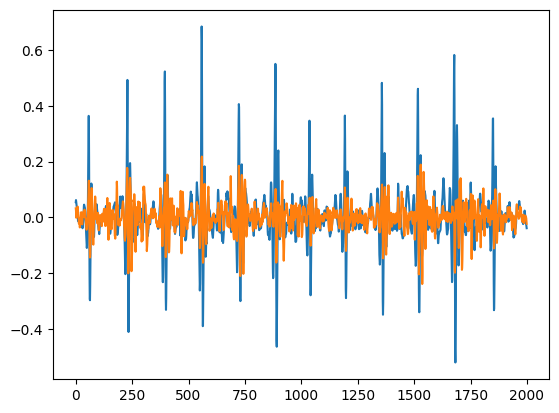

In [29]:
# mutual information for signal x and y
from sklearn.metrics import mutual_info_score
def mutual_information(x, y, bins=50):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
start = 3030
length = 2000
rcg1 = df['RCG'][obj_index-1][0][start:start+length]
rcg2 = df['RCG'][obj_index-1][29][start:start+length]
print(mutual_information(rcg1, rcg2), np.corrcoef(rcg1, rcg2)[0, 1])
plt.plot(rcg1)
plt.plot(rcg2)
plt.style.use("default")
# plt.show()


In [7]:
obj_index = 78
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_200/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_ecg/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle/'
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_pulse/'
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/'
params.save_path = '/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/'
# state_dict_path = f'/home/zhangyuanyuan/radarODE_plus/Model_saved/best_model_cross_vali_{(obj_index-9)//8+1}_ce_.pth'
set_random_seed(params.seed)
params.test_bs = 1
params.aug_snr = 3
params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt' # best for training with step dataset
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_1.pt' # best for EGA, weight for task 1 = 5
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_10_save.pt'
method = 'Aligned_MTL'
# method = 'GLS'
# method = 'UW'
method = 'GradVac'
method = 'EGA'
# params.load_path=f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_{method}.pt' 
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_3.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_ode.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_sv0.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EW_1.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_ode.pt'

# define tasks
task_dict = {'ECG_shape': {'metrics': ['MSE', 'CE', 'norm_MSE'],
                            'metrics_fn': shapeMetric(),
                            'loss_fn': shapeLoss(),
                            'weight': [0, 0, 0]},
                'PPI': {'metrics': ['CE', 'PPI_sec'],
                        'metrics_fn': ppiMetric(),
                        'loss_fn': ppiLoss(),
                        'weight': [0, 0]},
                'Anchor': {'metrics': ['mse'],
                        'metrics_fn': anchorMetric(),
                        'loss_fn': anchorLoss(),
                        'weight': [0]}}

# task_dict = {'Anchor': {'metrics': ['mse'],
#                         'metrics_fn': anchorMetric(),
#                         'loss_fn': anchorLoss(),
#                         'weight': [0]}}
ID_test = np.array([75, 76, 77, 78, 80, 81, 82, 83, 84, 85])

In [88]:

# ID_test = np.array([91])
# ID_test = np.arange(92, 93)
ID_test = np.array([75, 76, 77, 78,79, 80, 81, 82, 83, 84, 85])
# ID_test = np.array([79])
ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
aug_snrr = [100, 6, 3,2,1, 0, -3, -6, -8]
aug_snrr = [100, 100.5,101,101.5,102,102.5]
aug_snrr = [4,2,1,0]
aug_snrr = [112.5,113]
# aug_snrr = [113]
for params.aug_snr in aug_snrr:
    print(params.aug_snr)
    rmse_final, pcc_final, len_error, time_error_final, MDR_final = [], [], [], [], []
    for obj_index in ID_test:
        radarODE_test_set = dataset_concat(ID_selected=np.array([obj_index]), data_root=params.dataset_path, aug_snr = params.aug_snr)
        testloader = torch.utils.data.DataLoader(dataset=radarODE_test_set, batch_size=params.test_bs, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
        kwargs, optim_param, scheduler_param = prepare_args(params)
        # # define backbone and en/decoders
        def encoder_class(): 
            return backbone(in_channels=50)
        num_out_channels = {'PPI': 260, 'Anchor': 200}
        decoders = nn.ModuleDict({'ECG_shape': shapeDecoder(),
                                    'PPI': PPI_decoder(output_dim=num_out_channels['PPI']),
                                    # 'Anchor': PPI_decoder(output_dim=num_out_channels['Anchor'])})
                                    'Anchor': anchor_decoder()})

        class radarODE_plus(Trainer):
            def __init__(self, task_dict, weighting, architecture, encoder_class,
                            decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
                super(radarODE_plus, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, modelName=f'{weighting}', **kwargs)
        radarODE_plus_model = radarODE_plus(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders, 
        rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param, save_path=params.save_path, load_path=params.load_path, **kwargs)
        Inputs, Preds, Gts, Losses, improvement = radarODE_plus_model.test_visiual(testloader)
        ECG_gts, ECG_pred = [], []
        PPI_gts, PPI_pred = [], []
        Anchor_gts, Anchor_pred =[], []
        ssts, masks = [], []
        losses_ppi, losses_mse, losses_anchor, losses_mtl = [], [], [], []
        for i in range(len(Preds)):
            ECG_gts.append(Gts[i]['ECG_shape'].detach().cpu().numpy().squeeze())
            ECG_pred.append(Preds[i]['ECG_shape'].detach().cpu().numpy().squeeze())
            PPI_gts.append(Gts[i]['PPI'].detach().cpu().numpy().squeeze())
            PPI_pred.append(Preds[i]['PPI'].detach().cpu().numpy().squeeze())
            mask, loss_ppi = cross_entropy_loss_ppi(Preds[i]['PPI'], Gts[i]['PPI'])
            masks.append(mask.detach().cpu().numpy().astype(float).squeeze())
            Anchor_gts.append(Gts[i]['Anchor'].detach().cpu().numpy().squeeze())
            Anchor_pred.append(Preds[i]['Anchor'].detach().cpu().numpy().squeeze())
            
            ssts.append(Inputs[i][0].detach().cpu().numpy().astype(float))
            losses_mse.append(Losses[i][0].item())
            losses_ppi.append(loss_ppi.item())
            losses_anchor.append(Losses[i][2].item())

        # ssts = np.array(ssts)
        ECG_gts, ECG_pred, PPI_gts, PPI_pred, Anchor_gts, Anchor_pred = np.array(ECG_gts), np.array(ECG_pred), np.array(PPI_gts), np.array(PPI_pred), np.array(Anchor_gts), np.array(Anchor_pred)
        masks = np.array(masks)
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        df = mat2df(obj_index)
        # task 1
        ecg_shape_rmse = np.array([])
        mses = np.array([])
        cors = np.array([])
        for i in range(0, len(ECG_gts)):
            ecg_gts=ECG_gts[i]
            ecg_gts=down_sample(ecg_gts, 200)
            ecg_pred=ECG_pred[i][:200]
            factor = 1/(np.max(ecg_gts)-np.min(ecg_gts))
            ecg_min = np.min(ecg_gts)
            ecg_gts = norm_ecg(ecg_gts)
            ecg_pred = norm_ecg(ecg_pred)
            mse=mean_squared_error(ecg_gts/factor, ecg_pred/factor)
            mses = np.append(mses, (mse))
            ecg_shape_rmse = np.append(ecg_shape_rmse, np.sqrt(mse))
            cor = np.corrcoef(ecg_gts, ecg_pred)[0,1]
            cors = np.append(cors, cor)
        print("RMSE Mean:",np.mean(ecg_shape_rmse),"Median:",np.median(ecg_shape_rmse), "Cor", np.median(cors))
        rmse_final.append(np.median(ecg_shape_rmse)), pcc_final.append(np.median(cors))
        # # task 2
        ppi_pred = np.argmax(np.array(PPI_pred), axis=1)
        ppi_gts = np.argmax(np.array(masks), axis=1)
        # rmse
        ppi_rmse = np.sqrt(mean_squared_error(ppi_gts, ppi_pred))/200
        print("len_error", ppi_rmse)
        len_error.append(ppi_rmse)
        # task 3
        peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
        R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))  
        ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
        seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
        step =160
        margin = 300 # eliminate the first and last 100 points
        seg_length = 800
        peaks_pred_all = np.array([])
        for i in range(0, len(Anchor_pred)):
            start_index = i*step
            # if i >= len(seg_df['start'])-1:
            #     break
            R_selected_index = np.where((R_peaks > seg_df['start'][i]) & (R_peaks < seg_df['start'][i+1]))[0][0]
            start_index = R_peaks[R_selected_index]-400
            # start_index = seg_df['start'][i] - (800-(seg_df['start'][i+1]-seg_df['start'][i]))//2
            pred_org = norm_ecg(down_sample((Anchor_pred[i]), seg_length))
            pred = non_maximum_suppression_1d(pred_org, 0.7)
            smooth_pred = norm_ecg(smooth2nd(pred_org, 15))
            selected_pred = pred_org
            peaks_pred = peakutils.indexes(selected_pred, thres=0.75, min_dist=40)
            peaks_pred_all = np.append(peaks_pred_all, peaks_pred+start_index) 
        peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all<0)))
        peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all>35505)))
        peak_com = combine_close_peaks(peaks_pred_all, 30)
        offset, MDR = offset_calcu(R_peaks, peak_com, 30) if len(peak_com)>0 else (0, 1)
        anchor_error = metric_anchor(R_peaks, peak_com-offset, 30) if len(peak_com)>0 else 0
        _, MDR = offset_calcu(R_peaks, peak_com-offset, 30) if len(peak_com)>0 else (0, 1)
        _, peaks_final = accurate_peak(R_peaks, peaks_pred_all-offset, 50)
        # MDR = (len(missed_peaks))/len(R_peaks)
        print(offset)
        MDR_final.append(MDR), time_error_final.append(anchor_error)
        ecg_final = np.zeros(35505)+0.433
        seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
        R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))  
        start_array, end_array = seg_df['start'].values, seg_df['end'].values
        for i in range(0, len(peaks_final)):
            temp_anchor = peaks_final[i].astype(int)
            try:
                index = np.where((temp_anchor>=start_array) & (temp_anchor<end_array))[0][0]
            except:
                continue
            if index >= len(ECG_pred)-1:
                continue
            temp_ecg = down_sample(ECG_pred[index], ppi_pred[index])
            pred_R_index = np.where(temp_ecg == np.max(temp_ecg))[0][0]
            ahead, behiend = pred_R_index, len(temp_ecg)-pred_R_index
            if temp_anchor-ahead<0 or temp_anchor+behiend>35505:
                continue
            # align the temp_ecg based on the pred_R_index and temp_anchor
            ecg_final[temp_anchor-ahead:temp_anchor] = temp_ecg[:ahead]
            ecg_final[temp_anchor:temp_anchor+behiend] = temp_ecg[ahead:]
        for i in range(1, len(ecg_final)-30):
            if ecg_final[i]==0.433:
                for j in range(0, 30):
                    if ecg_final[i+j]!=0.433:
                        end = ecg_final[i+j]
                        break
                    else:
                        end = 0.433
                # interpolate the missing value
                start = ecg_final[i-1]
                ecg_final[i:i+j] = np.linspace(start, end, j)
        np.save(os.path.join(pred_all_root, f'{obj_index}_shape_mtl_{params.aug_snr}dB.npy'), ecg_final)
    np.save(os.path.join(interval_root, f'MDR_mtl_{params.aug_snr}dB.npy'), [np.median(len_error),np.median(time_error_final), np.median(MDR_final)] )
    # print([np.median(time_error_final), np.median(MDR_final)])


    
    

112.5
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
000


  0%|          | 0/227 [00:00<?, ?it/s]



0
0


  5%|▍         | 11/227 [00:00<00:08, 26.89it/s]

0


  6%|▌         | 14/227 [00:00<00:08, 26.55it/s]

0


 13%|█▎        | 29/227 [00:01<00:06, 32.69it/s]

0


 15%|█▍        | 33/227 [00:01<00:05, 33.73it/s]

0


 16%|█▋        | 37/227 [00:01<00:06, 31.53it/s]

0


 18%|█▊        | 41/227 [00:01<00:06, 30.37it/s]

0


 22%|██▏       | 49/227 [00:01<00:05, 30.63it/s]

0


 23%|██▎       | 53/227 [00:01<00:06, 28.43it/s]

0


 26%|██▋       | 60/227 [00:02<00:05, 30.47it/s]

0
0


 33%|███▎      | 74/227 [00:02<00:05, 28.48it/s]

0


 34%|███▍      | 77/227 [00:02<00:05, 28.25it/s]

0
0
0


 38%|███▊      | 87/227 [00:02<00:04, 30.79it/s]

0
0


 40%|████      | 91/227 [00:03<00:04, 30.19it/s]

0


 42%|████▏     | 95/227 [00:03<00:04, 31.50it/s]

0
0


 44%|████▎     | 99/227 [00:03<00:04, 31.43it/s]

0


 48%|████▊     | 110/227 [00:03<00:03, 29.38it/s]

0


 52%|█████▏    | 119/227 [00:04<00:03, 28.51it/s]

0


 55%|█████▌    | 125/227 [00:04<00:03, 27.97it/s]

0


 58%|█████▊    | 131/227 [00:04<00:03, 28.18it/s]

0


 60%|██████    | 137/227 [00:04<00:03, 28.42it/s]

0


 62%|██████▏   | 140/227 [00:04<00:03, 28.54it/s]

0


 63%|██████▎   | 143/227 [00:04<00:02, 28.65it/s]

0


 67%|██████▋   | 153/227 [00:05<00:02, 28.85it/s]

0


 71%|███████▏  | 162/227 [00:05<00:02, 28.79it/s]

0


 74%|███████▍  | 168/227 [00:05<00:02, 29.14it/s]

0


 77%|███████▋  | 174/227 [00:06<00:01, 29.47it/s]

0


 78%|███████▊  | 177/227 [00:06<00:01, 29.57it/s]

0
0


 80%|███████▉  | 181/227 [00:06<00:01, 29.71it/s]

0


 83%|████████▎ | 188/227 [00:06<00:01, 29.81it/s]

0


 84%|████████▍ | 191/227 [00:06<00:01, 29.75it/s]

0
0


 85%|████████▌ | 194/227 [00:06<00:01, 29.68it/s]

0


 89%|████████▉ | 202/227 [00:06<00:00, 33.08it/s]

0


 91%|█████████ | 206/227 [00:07<00:00, 33.05it/s]

0


100%|██████████| 227/227 [00:07<00:00, 29.82it/s]


TEST: 0.0054 0.0067 0.0054 5.2856 | 2.8834 0.0110 2.8834 | 0.0084 62.4150 | Time: 7.6189

2024-07-23 13:31:20
RMSE Mean: 0.07175241669851025 Median: 0.06778142105914096 Cor 0.9087146748138484
len_error 0.008679308525209305
-13.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/223 [00:00<?, ?it/s]

00

0
0
0


  1%|          | 2/223 [00:00<00:14, 15.23it/s]

0


 16%|█▌        | 35/223 [00:01<00:06, 28.25it/s]

0
0


 21%|██        | 46/223 [00:01<00:05, 30.00it/s]

0


 24%|██▍       | 54/223 [00:01<00:05, 31.34it/s]

0


 26%|██▌       | 58/223 [00:02<00:05, 32.50it/s]

0


 28%|██▊       | 62/223 [00:02<00:05, 31.49it/s]

0


 30%|██▉       | 66/223 [00:02<00:05, 30.20it/s]

0
0


 31%|███▏      | 70/223 [00:02<00:04, 30.75it/s]

0


 35%|███▍      | 78/223 [00:02<00:04, 31.10it/s]

0
0


 37%|███▋      | 82/223 [00:02<00:04, 30.00it/s]

0
0


 42%|████▏     | 94/223 [00:03<00:03, 33.81it/s]

0


 44%|████▍     | 98/223 [00:03<00:03, 32.62it/s]

0


 46%|████▌     | 102/223 [00:03<00:03, 31.42it/s]

0


 49%|████▉     | 109/223 [00:03<00:04, 27.85it/s]

0
0


 52%|█████▏    | 115/223 [00:03<00:04, 26.46it/s]

0


 53%|█████▎    | 118/223 [00:04<00:03, 26.69it/s]

0
0


 54%|█████▍    | 121/223 [00:04<00:03, 27.14it/s]

0


 56%|█████▌    | 124/223 [00:04<00:03, 27.28it/s]

0


 58%|█████▊    | 130/223 [00:04<00:03, 27.61it/s]

0


 62%|██████▏   | 139/223 [00:04<00:02, 28.28it/s]

0


 64%|██████▎   | 142/223 [00:04<00:02, 28.17it/s]

0


 65%|██████▌   | 145/223 [00:05<00:02, 28.09it/s]

0


 69%|██████▉   | 154/223 [00:05<00:02, 28.63it/s]

0


 70%|███████   | 157/223 [00:05<00:02, 28.47it/s]

0


 72%|███████▏  | 160/223 [00:05<00:02, 28.52it/s]

0


 73%|███████▎  | 163/223 [00:05<00:02, 28.66it/s]

0


 87%|████████▋ | 193/223 [00:06<00:01, 27.97it/s]

0


 89%|████████▉ | 199/223 [00:07<00:00, 24.56it/s]

0
0


 91%|█████████ | 202/223 [00:07<00:00, 25.26it/s]

0
0


 92%|█████████▏| 205/223 [00:07<00:00, 26.06it/s]

0


100%|██████████| 223/223 [00:07<00:00, 28.50it/s]


TEST: 0.0040 0.0049 0.0040 5.2851 | 2.4902 0.0118 2.4902 | 0.0084 62.3013 | Time: 7.8335

2024-07-23 13:31:32
RMSE Mean: 0.05229385819066493 Median: 0.04674517363657609 Cor 0.9677596260895481
len_error 0.008384001420600296
-8.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0
0


  1%|          | 2/225 [00:00<00:12, 17.35it/s]

0


  5%|▌         | 12/225 [00:00<00:07, 28.83it/s]

0


  7%|▋         | 16/225 [00:00<00:06, 31.52it/s]

0


 11%|█         | 24/225 [00:00<00:06, 29.99it/s]

0


 16%|█▌        | 35/225 [00:01<00:06, 28.17it/s]

0
0


 17%|█▋        | 38/225 [00:01<00:06, 27.31it/s]

0


 19%|█▊        | 42/225 [00:01<00:06, 29.08it/s]

0
0


 24%|██▍       | 54/225 [00:01<00:05, 32.48it/s]

0


 28%|██▊       | 62/225 [00:02<00:05, 32.20it/s]

0
0


 29%|██▉       | 66/225 [00:02<00:04, 33.16it/s]

0
0
0


 35%|███▍      | 78/225 [00:02<00:04, 29.43it/s]

0
0


 36%|███▌      | 81/225 [00:02<00:04, 29.26it/s]

0


 37%|███▋      | 84/225 [00:02<00:04, 29.32it/s]

0


 40%|████      | 90/225 [00:03<00:04, 29.35it/s]

0


 44%|████▍     | 99/225 [00:03<00:04, 29.50it/s]

0


 47%|████▋     | 105/225 [00:03<00:04, 29.44it/s]

0


 48%|████▊     | 108/225 [00:03<00:03, 29.41it/s]

0
0


 51%|█████     | 114/225 [00:03<00:03, 29.43it/s]

0


 52%|█████▏    | 117/225 [00:03<00:03, 29.38it/s]

0


 53%|█████▎    | 120/225 [00:04<00:03, 29.47it/s]

0


 55%|█████▍    | 123/225 [00:04<00:03, 29.29it/s]

0


 60%|██████    | 135/225 [00:04<00:03, 29.23it/s]

0


 63%|██████▎   | 141/225 [00:04<00:02, 29.07it/s]

0


 64%|██████▍   | 144/225 [00:04<00:02, 28.54it/s]

0


 67%|██████▋   | 150/225 [00:05<00:02, 28.31it/s]

0


 68%|██████▊   | 154/225 [00:05<00:02, 30.26it/s]

0


 70%|███████   | 158/225 [00:05<00:02, 31.59it/s]

0


 72%|███████▏  | 162/225 [00:05<00:01, 33.08it/s]

0


 74%|███████▍  | 166/225 [00:05<00:01, 34.31it/s]

0
0


 77%|███████▋  | 174/225 [00:05<00:01, 31.01it/s]

0


 84%|████████▍ | 189/225 [00:06<00:01, 29.46it/s]

0


 85%|████████▌ | 192/225 [00:06<00:01, 29.24it/s]

0


 88%|████████▊ | 198/225 [00:06<00:00, 29.08it/s]

0


 89%|████████▉ | 201/225 [00:06<00:00, 29.08it/s]

0


 91%|█████████ | 204/225 [00:06<00:00, 29.14it/s]

0


100%|██████████| 225/225 [00:07<00:00, 29.90it/s]


TEST: 0.0036 0.0043 0.0036 5.2849 | 2.8462 0.0122 2.8462 | 0.0070 62.1822 | Time: 7.5316

2024-07-23 13:31:43
RMSE Mean: 0.05244489712149857 Median: 0.04684411270107483 Cor 0.9597619457226977
len_error 0.011075498483890767
2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0

  0%|          | 0/223 [00:00<?, ?it/s]


0


  3%|▎         | 6/223 [00:00<00:08, 26.51it/s]

0


  4%|▍         | 9/223 [00:00<00:07, 27.46it/s]

0


  9%|▊         | 19/223 [00:00<00:07, 27.30it/s]

0
0


 10%|▉         | 22/223 [00:00<00:07, 27.15it/s]

0
0


 11%|█         | 25/223 [00:00<00:07, 27.49it/s]

0


 13%|█▎        | 28/223 [00:01<00:06, 27.89it/s]

0


 17%|█▋        | 37/223 [00:01<00:06, 28.12it/s]

0


 18%|█▊        | 40/223 [00:01<00:06, 28.30it/s]

0


 19%|█▉        | 43/223 [00:01<00:06, 28.24it/s]

0


 25%|██▍       | 55/223 [00:01<00:05, 28.71it/s]

0


 26%|██▌       | 58/223 [00:02<00:05, 28.59it/s]

0


 33%|███▎      | 73/223 [00:02<00:05, 28.71it/s]

0
0


 35%|███▌      | 79/223 [00:02<00:05, 28.79it/s]

0


 37%|███▋      | 82/223 [00:02<00:05, 28.14it/s]

0


 42%|████▏     | 94/223 [00:03<00:04, 28.79it/s]

0
0


 43%|████▎     | 97/223 [00:03<00:04, 29.01it/s]

0


 45%|████▍     | 100/223 [00:03<00:04, 29.08it/s]

0
0


 48%|████▊     | 106/223 [00:03<00:04, 29.19it/s]

0
0


 49%|████▉     | 109/223 [00:03<00:03, 29.21it/s]

0


 50%|█████     | 112/223 [00:03<00:03, 29.32it/s]

0


 52%|█████▏    | 115/223 [00:04<00:03, 28.89it/s]

0


 53%|█████▎    | 118/223 [00:04<00:03, 28.85it/s]

0
0


 62%|██████▏   | 139/223 [00:04<00:02, 29.22it/s]

0


 65%|██████▌   | 145/223 [00:05<00:02, 29.45it/s]

0


 66%|██████▋   | 148/223 [00:05<00:02, 29.34it/s]

0


 68%|██████▊   | 151/223 [00:05<00:02, 29.29it/s]

0
0


 73%|███████▎  | 163/223 [00:05<00:02, 29.31it/s]

0


 76%|███████▌  | 169/223 [00:05<00:01, 28.99it/s]

0


 80%|███████▉  | 178/223 [00:06<00:01, 28.86it/s]

0


 81%|████████  | 181/223 [00:06<00:01, 28.90it/s]

0


 84%|████████▍ | 187/223 [00:06<00:01, 29.22it/s]

0


 85%|████████▌ | 190/223 [00:06<00:01, 29.18it/s]

0


 87%|████████▋ | 193/223 [00:06<00:01, 29.09it/s]

0


 91%|█████████ | 202/223 [00:07<00:00, 29.33it/s]

0


100%|██████████| 223/223 [00:07<00:00, 28.82it/s]


TEST: 0.0086 0.0094 0.0086 5.2882 | 2.3165 0.0120 2.3165 | 0.0066 62.0926 | Time: 7.7438

2024-07-23 13:31:55
RMSE Mean: 0.07297746826325811 Median: 0.07160019044506087 Cor 0.8663152574394548
len_error 0.00738134844948641
-1.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0

  0%|          | 0/269 [00:00<?, ?it/s]


0
0


  2%|▏         | 5/269 [00:00<00:13, 19.50it/s]

0
0
0


  3%|▎         | 8/269 [00:00<00:12, 21.60it/s]

0


  5%|▌         | 14/269 [00:00<00:10, 25.05it/s]

0
0


  6%|▋         | 17/269 [00:00<00:09, 26.05it/s]

0


  7%|▋         | 20/269 [00:00<00:09, 26.58it/s]

0


 11%|█         | 29/269 [00:01<00:08, 27.42it/s]

0
0


 13%|█▎        | 36/269 [00:01<00:08, 27.90it/s]

0


 14%|█▍        | 39/269 [00:01<00:08, 28.12it/s]

0


 16%|█▌        | 42/269 [00:01<00:08, 28.12it/s]

0


 18%|█▊        | 48/269 [00:01<00:07, 28.40it/s]

0


 19%|█▉        | 51/269 [00:01<00:07, 28.53it/s]

0


 21%|██        | 57/269 [00:02<00:07, 28.60it/s]

0


 22%|██▏       | 60/269 [00:02<00:07, 28.05it/s]

0
0


 25%|██▍       | 66/269 [00:02<00:07, 28.06it/s]

0


 26%|██▌       | 69/269 [00:02<00:07, 28.15it/s]

0


 27%|██▋       | 72/269 [00:02<00:06, 28.34it/s]

0


 28%|██▊       | 75/269 [00:02<00:06, 28.38it/s]

0


 29%|██▉       | 78/269 [00:02<00:06, 28.39it/s]

0


 30%|███       | 81/269 [00:02<00:06, 28.32it/s]

0
0


 32%|███▏      | 87/269 [00:03<00:06, 28.68it/s]

0
0


 40%|████      | 108/269 [00:03<00:05, 28.16it/s]

0


 42%|████▏     | 114/269 [00:04<00:05, 28.58it/s]

0


 45%|████▍     | 121/269 [00:04<00:04, 30.88it/s]

0
0


 46%|████▋     | 125/269 [00:04<00:04, 32.85it/s]

0
0


 49%|████▉     | 133/269 [00:04<00:03, 34.68it/s]

0


 54%|█████▍    | 145/269 [00:05<00:03, 31.61it/s]

0


 57%|█████▋    | 153/269 [00:05<00:04, 28.27it/s]

0
0


 64%|██████▎   | 171/269 [00:06<00:03, 25.80it/s]

0


 66%|██████▌   | 177/269 [00:06<00:03, 26.78it/s]

0


 67%|██████▋   | 180/269 [00:06<00:03, 27.06it/s]

0


 70%|███████   | 189/269 [00:06<00:02, 28.48it/s]

0


 72%|███████▏  | 195/269 [00:06<00:02, 28.75it/s]

0


 74%|███████▎  | 198/269 [00:07<00:02, 28.87it/s]

0
0
0


 77%|███████▋  | 207/269 [00:07<00:02, 28.82it/s]

0


 80%|███████▉  | 214/269 [00:07<00:01, 29.32it/s]

0


 86%|████████▌ | 232/269 [00:08<00:01, 28.93it/s]

0


 87%|████████▋ | 235/269 [00:08<00:01, 28.73it/s]

0


 90%|████████▉ | 241/269 [00:08<00:00, 28.75it/s]

0


100%|██████████| 269/269 [00:09<00:00, 28.39it/s]


TEST: 0.0740 0.0882 0.0740 5.3147 | 4.3079 0.0561 4.3079 | 0.0076 74.9273 | Time: 9.4832

2024-07-23 13:32:08
RMSE Mean: 0.28069703902625287 Median: 0.27935217718641897 Cor -0.19433543987446292
len_error 0.11583662061964656
2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0
0

  0%|          | 0/189 [00:00<?, ?it/s]


0


  3%|▎         | 5/189 [00:00<00:08, 21.09it/s]

0


  4%|▍         | 8/189 [00:00<00:07, 23.98it/s]

0


  7%|▋         | 14/189 [00:00<00:06, 26.81it/s]

0


 11%|█         | 20/189 [00:00<00:06, 27.85it/s]

0


 12%|█▏        | 23/189 [00:00<00:05, 28.13it/s]

0


 15%|█▌        | 29/189 [00:01<00:05, 28.34it/s]

0


 17%|█▋        | 32/189 [00:01<00:05, 28.43it/s]

0


 20%|██        | 38/189 [00:01<00:05, 26.05it/s]

0


 26%|██▋       | 50/189 [00:01<00:05, 25.29it/s]

0


 28%|██▊       | 53/189 [00:02<00:05, 25.54it/s]

0


 36%|███▌      | 68/189 [00:02<00:04, 24.71it/s]

0


 39%|███▉      | 74/189 [00:02<00:04, 24.47it/s]

0
0


 42%|████▏     | 80/189 [00:03<00:04, 24.89it/s]

0


 50%|█████     | 95/189 [00:03<00:03, 24.23it/s]

0


 55%|█████▌    | 104/189 [00:04<00:03, 24.04it/s]

0
0


 57%|█████▋    | 107/189 [00:04<00:03, 23.76it/s]

0
0


 58%|█████▊    | 110/189 [00:04<00:03, 23.89it/s]

0


 61%|██████▏   | 116/189 [00:04<00:03, 23.73it/s]

0


 69%|██████▉   | 131/189 [00:05<00:02, 23.68it/s]

0


 71%|███████   | 134/189 [00:05<00:02, 23.84it/s]

0


 77%|███████▋  | 146/189 [00:05<00:01, 24.82it/s]

0


 79%|███████▉  | 149/189 [00:05<00:01, 25.97it/s]

0
0


 82%|████████▏ | 155/189 [00:06<00:01, 27.44it/s]

0


 84%|████████▎ | 158/189 [00:06<00:01, 27.80it/s]

0


 85%|████████▌ | 161/189 [00:06<00:00, 28.08it/s]

0
0


 87%|████████▋ | 164/189 [00:06<00:00, 27.99it/s]

0
0


 88%|████████▊ | 167/189 [00:06<00:00, 28.13it/s]

0
0


100%|██████████| 189/189 [00:07<00:00, 25.76it/s]


TEST: 0.0080 0.0106 0.0080 5.2859 | 2.9698 0.0119 2.9698 | 0.0079 62.2676 | Time: 7.3417

2024-07-23 13:32:19
RMSE Mean: 0.09012205203816014 Median: 0.08152389049971452 Cor 0.9133595491189858
len_error 0.009193683131575153
-8.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


  0%|          | 0/189 [00:00<?, ?it/s]

0
0
0


  3%|▎         | 5/189 [00:00<00:08, 22.62it/s]

0
0


  4%|▍         | 8/189 [00:00<00:07, 24.74it/s]

0


  6%|▌         | 11/189 [00:00<00:06, 26.27it/s]

0


  8%|▊         | 15/189 [00:00<00:06, 28.09it/s]

0
0


 10%|▉         | 18/189 [00:00<00:06, 28.03it/s]

0


 11%|█         | 21/189 [00:00<00:05, 28.22it/s]

0


 17%|█▋        | 33/189 [00:01<00:05, 27.75it/s]

0
0


 19%|█▉        | 36/189 [00:01<00:05, 28.15it/s]

0


 27%|██▋       | 51/189 [00:01<00:04, 32.26it/s]

0


 29%|██▉       | 55/189 [00:01<00:04, 32.78it/s]

0


 31%|███       | 59/189 [00:02<00:04, 31.53it/s]

0


 39%|███▉      | 74/189 [00:02<00:03, 29.70it/s]

0


 47%|████▋     | 89/189 [00:03<00:03, 29.32it/s]

0
0
0


 50%|█████     | 95/189 [00:03<00:03, 29.39it/s]

0


 55%|█████▌    | 104/189 [00:03<00:02, 29.25it/s]

0


 57%|█████▋    | 107/189 [00:03<00:02, 29.28it/s]

0


 58%|█████▊    | 110/189 [00:03<00:02, 29.38it/s]

0


 63%|██████▎   | 119/189 [00:04<00:02, 29.45it/s]

0


 66%|██████▌   | 125/189 [00:04<00:02, 29.50it/s]

0


 68%|██████▊   | 128/189 [00:04<00:02, 29.37it/s]

0


 72%|███████▏  | 137/189 [00:04<00:01, 28.94it/s]

0


 74%|███████▍  | 140/189 [00:04<00:01, 28.95it/s]

0


 79%|███████▉  | 149/189 [00:05<00:01, 28.96it/s]

0
0


 80%|████████  | 152/189 [00:05<00:01, 28.73it/s]

0


 87%|████████▋ | 164/189 [00:05<00:00, 28.58it/s]

0


 88%|████████▊ | 167/189 [00:05<00:00, 28.49it/s]

0
0
0


100%|██████████| 189/189 [00:06<00:00, 29.08it/s]


TEST: 0.0092 0.0121 0.0092 5.2870 | 2.7304 0.0142 2.7304 | 0.0063 61.9147 | Time: 6.5048

2024-07-23 13:32:29
RMSE Mean: 0.09002221836200144 Median: 0.08164959371650035 Cor 0.8963279393281425
len_error 0.010459040796915097
0.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


  0%|          | 0/196 [00:00<?, ?it/s]

0
0
0
00



  1%|          | 1/196 [00:00<00:21,  9.11it/s]

0


 10%|▉         | 19/196 [00:00<00:06, 27.04it/s]

0


 11%|█         | 22/196 [00:00<00:06, 26.03it/s]

0


 13%|█▎        | 25/196 [00:00<00:06, 26.23it/s]

0


 22%|██▏       | 43/196 [00:01<00:05, 27.91it/s]

0


 28%|██▊       | 55/196 [00:02<00:05, 28.08it/s]

0
0


 30%|██▉       | 58/196 [00:02<00:04, 28.23it/s]

0


 38%|███▊      | 74/196 [00:02<00:04, 29.86it/s]

0
0


 42%|████▏     | 82/196 [00:02<00:03, 32.98it/s]

0
0


 44%|████▍     | 86/196 [00:03<00:03, 33.69it/s]

0


 48%|████▊     | 94/196 [00:03<00:03, 32.98it/s]

0
0


 50%|█████     | 98/196 [00:03<00:03, 30.04it/s]

0


 54%|█████▎    | 105/196 [00:03<00:03, 27.23it/s]

0


 60%|██████    | 118/196 [00:04<00:03, 23.77it/s]

0


 63%|██████▎   | 124/196 [00:04<00:03, 22.70it/s]

0
0


 65%|██████▍   | 127/196 [00:04<00:02, 24.18it/s]

0


 68%|██████▊   | 133/196 [00:04<00:02, 26.21it/s]

0
0


 69%|██████▉   | 136/196 [00:04<00:02, 27.14it/s]

0


 71%|███████   | 139/196 [00:05<00:02, 27.26it/s]

0


 72%|███████▏  | 142/196 [00:05<00:01, 27.29it/s]

0


 74%|███████▍  | 145/196 [00:05<00:01, 27.26it/s]

0


 77%|███████▋  | 151/196 [00:05<00:01, 28.12it/s]

0


 79%|███████▊  | 154/196 [00:05<00:01, 28.29it/s]

0


 82%|████████▏ | 160/196 [00:05<00:01, 28.50it/s]

0


 86%|████████▌ | 169/196 [00:06<00:00, 28.87it/s]

0


 88%|████████▊ | 172/196 [00:06<00:00, 28.95it/s]

0


 89%|████████▉ | 175/196 [00:06<00:00, 28.93it/s]

0


 91%|█████████ | 178/196 [00:06<00:00, 28.96it/s]

0


100%|██████████| 196/196 [00:07<00:00, 27.85it/s]


TEST: 0.0180 0.0208 0.0180 5.2924 | 3.1045 0.0132 3.1045 | 0.0069 61.9548 | Time: 7.0429

2024-07-23 13:32:40
RMSE Mean: 0.12536875961790067 Median: 0.125253963412955 Cor 0.7556028414243233
len_error 0.01682745569912821
4.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/223 [00:00<?, ?it/s]

0


  1%|          | 2/223 [00:00<00:13, 16.81it/s]

0
0


  5%|▍         | 11/223 [00:00<00:08, 26.33it/s]

0


  6%|▋         | 14/223 [00:00<00:07, 26.89it/s]

0


  9%|▉         | 20/223 [00:00<00:07, 27.31it/s]

0
0


 10%|█         | 23/223 [00:00<00:07, 27.79it/s]

0


 14%|█▍        | 32/223 [00:01<00:06, 28.40it/s]

0
0


 16%|█▌        | 35/223 [00:01<00:06, 26.93it/s]

0


 17%|█▋        | 38/223 [00:01<00:07, 26.02it/s]

0


 18%|█▊        | 41/223 [00:01<00:07, 25.37it/s]

0


 21%|██        | 47/223 [00:01<00:06, 26.80it/s]

0


 22%|██▏       | 50/223 [00:01<00:06, 27.39it/s]

0


 24%|██▍       | 53/223 [00:01<00:06, 27.81it/s]

0


 25%|██▌       | 56/223 [00:02<00:05, 28.08it/s]

0


 26%|██▋       | 59/223 [00:02<00:05, 27.81it/s]

0


 28%|██▊       | 62/223 [00:02<00:05, 28.10it/s]

0


 32%|███▏      | 71/223 [00:02<00:05, 28.21it/s]

0


 35%|███▍      | 77/223 [00:02<00:05, 28.40it/s]

0
0


 37%|███▋      | 83/223 [00:03<00:04, 28.42it/s]

0


 42%|████▏     | 93/223 [00:03<00:04, 29.51it/s]

0


 47%|████▋     | 105/223 [00:03<00:04, 28.59it/s]

0


 48%|████▊     | 108/223 [00:03<00:03, 28.78it/s]

0


 50%|████▉     | 111/223 [00:04<00:03, 28.91it/s]

0


 51%|█████     | 114/223 [00:04<00:03, 29.02it/s]

0
0


 54%|█████▍    | 120/223 [00:04<00:03, 29.31it/s]

0
0


 65%|██████▍   | 144/223 [00:05<00:02, 29.22it/s]

0
0


 66%|██████▌   | 147/223 [00:05<00:02, 28.10it/s]

0


 67%|██████▋   | 150/223 [00:05<00:02, 26.24it/s]

0


 69%|██████▊   | 153/223 [00:05<00:02, 26.37it/s]

0


 72%|███████▏  | 160/223 [00:05<00:02, 28.15it/s]

0


 74%|███████▍  | 166/223 [00:05<00:02, 28.06it/s]

0


 78%|███████▊  | 175/223 [00:06<00:01, 28.50it/s]

0


 80%|███████▉  | 178/223 [00:06<00:01, 28.66it/s]

0


 84%|████████▍ | 188/223 [00:06<00:01, 30.30it/s]

0


 88%|████████▊ | 196/223 [00:06<00:00, 29.73it/s]

0


 90%|████████▉ | 200/223 [00:07<00:00, 30.89it/s]

0


100%|██████████| 223/223 [00:07<00:00, 28.39it/s]


TEST: 0.0146 0.0180 0.0146 5.2880 | 2.6722 0.0136 2.6722 | 0.0071 62.2669 | Time: 7.8620

2024-07-23 13:32:51
RMSE Mean: 0.12035271159637141 Median: 0.11396650188388506 Cor 0.7851123749510246
len_error 0.021016756074010073
-6.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0

  0%|          | 0/208 [00:00<?, ?it/s]

  2%|▏         | 5/208 [00:00<00:08, 23.75it/s]

0


  4%|▍         | 8/208 [00:00<00:07, 25.81it/s]

0
0


  5%|▌         | 11/208 [00:00<00:07, 26.78it/s]

0
0


  7%|▋         | 14/208 [00:00<00:07, 27.46it/s]

0


  8%|▊         | 17/208 [00:00<00:06, 27.98it/s]

0


 11%|█         | 23/208 [00:00<00:06, 27.87it/s]

0


 12%|█▎        | 26/208 [00:00<00:06, 27.76it/s]

0


 14%|█▍        | 29/208 [00:01<00:06, 27.86it/s]

0


 15%|█▌        | 32/208 [00:01<00:06, 27.66it/s]

0


 20%|█▉        | 41/208 [00:01<00:05, 28.34it/s]

0


 27%|██▋       | 56/208 [00:02<00:05, 28.03it/s]

0


 32%|███▏      | 66/208 [00:02<00:04, 28.94it/s]

0


 37%|███▋      | 76/208 [00:02<00:04, 28.30it/s]

0


 41%|████      | 85/208 [00:03<00:04, 26.56it/s]

0


 42%|████▏     | 88/208 [00:03<00:04, 27.03it/s]

0
0


 48%|████▊     | 100/208 [00:03<00:03, 28.09it/s]

0
0


 51%|█████     | 106/208 [00:03<00:03, 28.10it/s]

0


 54%|█████▍    | 113/208 [00:04<00:03, 29.07it/s]

0


 56%|█████▋    | 117/208 [00:04<00:03, 30.08it/s]

0


 58%|█████▊    | 121/208 [00:04<00:02, 30.68it/s]

0
0


 60%|██████    | 125/208 [00:04<00:02, 30.12it/s]

0


 62%|██████▏   | 129/208 [00:04<00:02, 29.88it/s]

0
0


 68%|██████▊   | 141/208 [00:04<00:01, 33.78it/s]

0


 72%|███████▏  | 149/208 [00:05<00:01, 29.67it/s]

0
0


 75%|███████▌  | 156/208 [00:05<00:01, 29.04it/s]

0
0


 76%|███████▋  | 159/208 [00:05<00:01, 28.90it/s]

0


 79%|███████▉  | 165/208 [00:05<00:01, 28.32it/s]

0


 81%|████████  | 168/208 [00:05<00:01, 28.54it/s]

0


 82%|████████▏ | 171/208 [00:05<00:01, 28.54it/s]

0


 86%|████████▌ | 178/208 [00:06<00:01, 29.06it/s]

0
0


 88%|████████▊ | 184/208 [00:06<00:00, 28.96it/s]

0


100%|██████████| 208/208 [00:07<00:00, 28.69it/s]


TEST: 0.0194 0.0224 0.0194 5.2917 | 2.6149 0.0089 2.6149 | 0.0062 62.1401 | Time: 7.2595

2024-07-23 13:33:02
RMSE Mean: 0.13542223600603365 Median: 0.13047812659217267 Cor 0.7483483848233236
len_error 0.01101790500817786
2.75
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/193 [00:00<?, ?it/s]

0


  1%|          | 1/193 [00:00<00:19,  9.98it/s]

0


  2%|▏         | 4/193 [00:00<00:09, 20.51it/s]

0


  7%|▋         | 13/193 [00:00<00:06, 27.07it/s]

0
0


  8%|▊         | 16/193 [00:00<00:06, 27.65it/s]

0


 10%|▉         | 19/193 [00:00<00:06, 28.04it/s]

0


 11%|█▏        | 22/193 [00:00<00:06, 28.24it/s]

0


 13%|█▎        | 25/193 [00:00<00:05, 28.47it/s]

0


 15%|█▍        | 28/193 [00:01<00:05, 28.44it/s]

0


 16%|█▌        | 31/193 [00:01<00:05, 28.44it/s]

0


 18%|█▊        | 34/193 [00:01<00:05, 28.51it/s]

0
0


 23%|██▎       | 45/193 [00:01<00:04, 32.49it/s]

0


 25%|██▌       | 49/193 [00:01<00:04, 33.83it/s]

0


 27%|██▋       | 53/193 [00:01<00:04, 33.76it/s]

0
0


 30%|██▉       | 57/193 [00:01<00:03, 34.68it/s]

0


 34%|███▎      | 65/193 [00:02<00:04, 31.86it/s]

0
0


 36%|███▌      | 69/193 [00:02<00:04, 30.85it/s]

0


 38%|███▊      | 73/193 [00:02<00:03, 30.38it/s]

0


 46%|████▌     | 89/193 [00:02<00:03, 32.13it/s]

0
0


 54%|█████▍    | 105/193 [00:03<00:02, 31.84it/s]

0


 56%|█████▋    | 109/193 [00:03<00:02, 32.43it/s]

0


 65%|██████▍   | 125/193 [00:04<00:02, 29.66it/s]

0
0
0


 66%|██████▋   | 128/193 [00:04<00:02, 29.46it/s]

0


 68%|██████▊   | 131/193 [00:04<00:02, 29.44it/s]

0


 79%|███████▉  | 152/193 [00:05<00:01, 26.37it/s]

0


 80%|████████  | 155/193 [00:05<00:01, 26.86it/s]

0


 82%|████████▏ | 158/193 [00:05<00:01, 27.24it/s]

0


 83%|████████▎ | 161/193 [00:05<00:01, 27.70it/s]

0


 85%|████████▍ | 164/193 [00:05<00:01, 28.11it/s]

0


 88%|████████▊ | 170/193 [00:05<00:00, 28.72it/s]

0


100%|██████████| 193/193 [00:06<00:00, 29.63it/s]


TEST: 0.0132 0.0162 0.0132 5.2851 | 3.1606 0.0131 3.1606 | 0.0060 62.0685 | Time: 6.5218

2024-07-23 13:33:12
RMSE Mean: 0.10894703532013861 Median: 0.09988523490356173 Cor 0.904205116236965
len_error 0.013209158386701786
1.0
113
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/227 [00:00<?, ?it/s]

0


  4%|▍         | 9/227 [00:00<00:07, 27.94it/s]

0


  7%|▋         | 15/227 [00:00<00:08, 25.89it/s]

0
0


  9%|▉         | 21/227 [00:00<00:08, 25.00it/s]

0


 11%|█         | 24/227 [00:00<00:08, 24.78it/s]

0


 13%|█▎        | 30/227 [00:01<00:08, 24.32it/s]

0
0


 15%|█▍        | 33/227 [00:01<00:07, 24.62it/s]

0
0
0


 20%|█▉        | 45/227 [00:01<00:06, 26.36it/s]

0


 22%|██▏       | 49/227 [00:01<00:06, 29.04it/s]

0


 25%|██▌       | 57/227 [00:02<00:05, 32.70it/s]

0


 27%|██▋       | 61/227 [00:02<00:05, 32.56it/s]

0


 29%|██▊       | 65/227 [00:02<00:05, 30.79it/s]

0
0


 30%|███       | 69/227 [00:02<00:05, 30.30it/s]

0


 34%|███▍      | 77/227 [00:02<00:04, 31.29it/s]

0


 36%|███▌      | 81/227 [00:02<00:04, 30.24it/s]

0
0


 41%|████      | 92/227 [00:03<00:04, 27.89it/s]

0


 42%|████▏     | 96/227 [00:03<00:04, 29.19it/s]

0


 44%|████▎     | 99/227 [00:03<00:04, 28.91it/s]

0


 49%|████▉     | 111/227 [00:04<00:04, 25.12it/s]

0


 52%|█████▏    | 117/227 [00:04<00:04, 24.51it/s]

0


 53%|█████▎    | 120/227 [00:04<00:04, 24.95it/s]

0


 54%|█████▍    | 123/227 [00:04<00:04, 25.42it/s]

0


 56%|█████▌    | 126/227 [00:04<00:03, 25.28it/s]

0


 58%|█████▊    | 132/227 [00:04<00:03, 25.91it/s]

0
0


 61%|██████    | 138/227 [00:05<00:03, 27.26it/s]

0


 62%|██████▏   | 141/227 [00:05<00:03, 27.24it/s]

0


 68%|██████▊   | 154/227 [00:05<00:02, 30.79it/s]

0
0


 70%|██████▉   | 158/227 [00:05<00:02, 30.77it/s]

0


 73%|███████▎  | 166/227 [00:06<00:02, 29.77it/s]

0


 77%|███████▋  | 175/227 [00:06<00:01, 29.09it/s]

0


 78%|███████▊  | 178/227 [00:06<00:01, 29.04it/s]

0


 84%|████████▎ | 190/227 [00:06<00:01, 29.06it/s]

0


 86%|████████▋ | 196/227 [00:07<00:01, 28.90it/s]

0
0


 88%|████████▊ | 199/227 [00:07<00:00, 28.76it/s]

0
0


100%|██████████| 227/227 [00:08<00:00, 27.94it/s]


TEST: 0.0052 0.0063 0.0052 5.2854 | 2.9001 0.0112 2.9001 | 0.0084 62.4160 | Time: 8.1343

2024-07-23 13:33:24
RMSE Mean: 0.07067714296354898 Median: 0.0657846153079927 Cor 0.9086810932375922
len_error 0.009202805548089513
-13.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0

  0%|          | 0/223 [00:00<?, ?it/s]

00




  9%|▉         | 20/223 [00:00<00:07, 27.17it/s]

0
0


 10%|█         | 23/223 [00:00<00:07, 27.25it/s]

0


 12%|█▏        | 26/223 [00:00<00:07, 27.52it/s]

0


 13%|█▎        | 29/223 [00:01<00:06, 27.74it/s]

0


 14%|█▍        | 32/223 [00:01<00:06, 27.86it/s]

0


 16%|█▌        | 35/223 [00:01<00:06, 28.06it/s]

0


 17%|█▋        | 38/223 [00:01<00:06, 28.13it/s]

0


 18%|█▊        | 41/223 [00:01<00:06, 28.24it/s]

0


 21%|██        | 47/223 [00:01<00:06, 27.30it/s]

0


 24%|██▍       | 53/223 [00:01<00:06, 27.89it/s]

0


 26%|██▋       | 59/223 [00:02<00:05, 28.16it/s]

0


 28%|██▊       | 62/223 [00:02<00:05, 28.25it/s]

0


 29%|██▉       | 65/223 [00:02<00:05, 28.24it/s]

0


 30%|███       | 68/223 [00:02<00:05, 28.20it/s]

0


 36%|███▌      | 80/223 [00:02<00:04, 28.60it/s]

0
0


 39%|███▉      | 87/223 [00:03<00:04, 29.76it/s]

0


 44%|████▍     | 98/223 [00:03<00:04, 29.38it/s]

0
0


 45%|████▌     | 101/223 [00:03<00:04, 27.23it/s]

0


 51%|█████     | 113/223 [00:03<00:03, 33.12it/s]

0


 52%|█████▏    | 117/223 [00:04<00:03, 32.40it/s]

0
0


 56%|█████▌    | 125/223 [00:04<00:03, 30.90it/s]

0


 58%|█████▊    | 129/223 [00:04<00:03, 30.26it/s]

0
0


 63%|██████▎   | 140/223 [00:04<00:02, 29.43it/s]

0
0


 64%|██████▍   | 143/223 [00:04<00:02, 29.01it/s]

0


 65%|██████▌   | 146/223 [00:05<00:02, 28.97it/s]

0


 67%|██████▋   | 149/223 [00:05<00:02, 29.02it/s]

0


 71%|███████   | 158/223 [00:05<00:02, 29.32it/s]

0


 72%|███████▏  | 161/223 [00:05<00:02, 29.28it/s]

0


 74%|███████▎  | 164/223 [00:05<00:02, 29.20it/s]

0
0


 76%|███████▌  | 170/223 [00:05<00:01, 29.20it/s]

0
0


 80%|████████  | 179/223 [00:06<00:01, 29.15it/s]

0


 86%|████████▌ | 191/223 [00:06<00:01, 28.37it/s]

0


 91%|█████████ | 203/223 [00:07<00:00, 28.98it/s]

0


100%|██████████| 223/223 [00:07<00:00, 28.87it/s]


TEST: 0.0040 0.0048 0.0040 5.2851 | 2.4891 0.0120 2.4891 | 0.0084 62.3017 | Time: 7.7309

2024-07-23 13:33:35
RMSE Mean: 0.05247767604140699 Median: 0.04734464208636519 Cor 0.9658590316556889
len_error 0.008363919951235345
-8.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


  0%|          | 0/225 [00:00<?, ?it/s]

00

0
0
0


  1%|          | 2/225 [00:00<00:11, 19.15it/s]

0
0


  3%|▎         | 6/225 [00:00<00:08, 26.26it/s]

0


  7%|▋         | 15/225 [00:00<00:08, 24.24it/s]

0
0


  9%|▉         | 21/225 [00:00<00:08, 24.21it/s]

0


 12%|█▏        | 27/225 [00:01<00:07, 26.48it/s]

0


 13%|█▎        | 30/225 [00:01<00:07, 26.11it/s]

0


 15%|█▍        | 33/225 [00:01<00:07, 26.18it/s]

0


 19%|█▊        | 42/225 [00:01<00:07, 25.06it/s]

0


 21%|██▏       | 48/225 [00:01<00:07, 24.57it/s]

0


 24%|██▍       | 54/225 [00:02<00:07, 24.29it/s]

0


 27%|██▋       | 60/225 [00:02<00:06, 24.31it/s]

0


 28%|██▊       | 63/225 [00:02<00:06, 24.23it/s]

0


 32%|███▏      | 73/225 [00:02<00:05, 27.08it/s]

0


 34%|███▍      | 77/225 [00:03<00:05, 28.05it/s]

0


 36%|███▌      | 80/225 [00:03<00:05, 27.88it/s]

0


 38%|███▊      | 86/225 [00:03<00:05, 27.43it/s]

0


 45%|████▌     | 102/225 [00:03<00:04, 28.65it/s]

0


 49%|████▉     | 110/225 [00:04<00:03, 31.62it/s]

0


 51%|█████     | 114/225 [00:04<00:03, 31.90it/s]

0
0


 54%|█████▍    | 122/225 [00:04<00:03, 30.68it/s]

0


 56%|█████▌    | 126/225 [00:04<00:03, 29.76it/s]

0
0


 57%|█████▋    | 129/225 [00:04<00:03, 29.26it/s]

0
0


 65%|██████▌   | 147/225 [00:05<00:02, 29.26it/s]

0


 67%|██████▋   | 150/225 [00:05<00:02, 28.91it/s]

0
0
0


 68%|██████▊   | 154/225 [00:05<00:02, 29.58it/s]

0


 72%|███████▏  | 161/225 [00:05<00:02, 29.62it/s]

0


 75%|███████▍  | 168/225 [00:06<00:01, 29.55it/s]

0


 76%|███████▌  | 171/225 [00:06<00:01, 29.38it/s]

0


 77%|███████▋  | 174/225 [00:06<00:01, 29.23it/s]

0


 80%|████████  | 181/225 [00:06<00:01, 29.95it/s]

0


 82%|████████▏ | 185/225 [00:06<00:01, 30.75it/s]

0


 84%|████████▍ | 189/225 [00:06<00:01, 32.26it/s]

0


 86%|████████▌ | 193/225 [00:06<00:00, 33.45it/s]

0


100%|██████████| 225/225 [00:07<00:00, 28.96it/s]


TEST: 0.0039 0.0046 0.0039 5.2851 | 2.7591 0.0117 2.7591 | 0.0070 62.1858 | Time: 7.7747

2024-07-23 13:33:47
RMSE Mean: 0.05432365530211027 Median: 0.04975613892965611 Cor 0.953183911750087
len_error 0.010066445913694332
2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


  0%|          | 0/223 [00:00<?, ?it/s]

0
0


  2%|▏         | 5/223 [00:00<00:09, 23.89it/s]

0


  5%|▍         | 11/223 [00:00<00:07, 26.96it/s]

0


  8%|▊         | 18/223 [00:00<00:07, 28.75it/s]

0


 11%|█         | 24/223 [00:00<00:06, 28.60it/s]

0


 12%|█▏        | 27/223 [00:00<00:06, 28.60it/s]

0


 14%|█▍        | 31/223 [00:01<00:06, 29.26it/s]

0


 18%|█▊        | 40/223 [00:01<00:06, 28.84it/s]

0


 25%|██▍       | 55/223 [00:01<00:05, 28.30it/s]

0


 27%|██▋       | 61/223 [00:02<00:05, 28.16it/s]

0


 33%|███▎      | 73/223 [00:02<00:05, 28.16it/s]

0
0


 35%|███▌      | 79/223 [00:02<00:05, 27.52it/s]

0
0


 37%|███▋      | 82/223 [00:02<00:05, 27.50it/s]

0


 39%|███▉      | 88/223 [00:03<00:04, 27.90it/s]

0


 41%|████      | 91/223 [00:03<00:04, 27.87it/s]

0


 42%|████▏     | 94/223 [00:03<00:04, 27.97it/s]

0


 43%|████▎     | 97/223 [00:03<00:04, 28.20it/s]

0


 50%|█████     | 112/223 [00:04<00:04, 27.63it/s]

0


 55%|█████▌    | 123/223 [00:04<00:03, 29.38it/s]

0


 57%|█████▋    | 126/223 [00:04<00:03, 29.30it/s]

0
0


 58%|█████▊    | 129/223 [00:04<00:03, 28.66it/s]

0


 61%|██████    | 136/223 [00:04<00:02, 29.64it/s]

0
0


 63%|██████▎   | 140/223 [00:04<00:02, 29.78it/s]

0
0


 66%|██████▌   | 147/223 [00:05<00:02, 31.31it/s]

0


 68%|██████▊   | 151/223 [00:05<00:02, 32.85it/s]

0


 71%|███████▏  | 159/223 [00:05<00:02, 29.68it/s]

0


 73%|███████▎  | 163/223 [00:05<00:02, 28.56it/s]

0
0


 77%|███████▋  | 172/223 [00:06<00:01, 27.76it/s]

0
0


 78%|███████▊  | 175/223 [00:06<00:01, 26.47it/s]

0


 84%|████████▍ | 187/223 [00:06<00:01, 27.84it/s]

0
0


 85%|████████▌ | 190/223 [00:06<00:01, 28.09it/s]

0


 88%|████████▊ | 196/223 [00:06<00:00, 27.91it/s]

0


 89%|████████▉ | 199/223 [00:07<00:00, 28.14it/s]

0


 92%|█████████▏| 205/223 [00:07<00:00, 28.41it/s]

0
0


100%|██████████| 223/223 [00:07<00:00, 28.65it/s]


TEST: 0.0088 0.0095 0.0088 5.2884 | 2.2530 0.0117 2.2530 | 0.0065 62.0830 | Time: 7.7897

2024-07-23 13:33:58
RMSE Mean: 0.0733748143686502 Median: 0.07152116170213588 Cor 0.8710580596097106
len_error 0.0071733812880077
-1.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/269 [00:00<?, ?it/s]

00

0


  1%|          | 2/269 [00:00<00:17, 15.20it/s]

0


  4%|▍         | 11/269 [00:00<00:10, 25.14it/s]

0


  5%|▌         | 14/269 [00:00<00:09, 26.24it/s]

0


  9%|▊         | 23/269 [00:00<00:08, 28.14it/s]

0


 10%|▉         | 26/269 [00:00<00:08, 28.20it/s]

0
0


 11%|█         | 29/269 [00:01<00:08, 28.21it/s]

0


 12%|█▏        | 32/269 [00:01<00:08, 28.50it/s]

0


 16%|█▋        | 44/269 [00:01<00:07, 28.36it/s]

0


 19%|█▊        | 50/269 [00:01<00:07, 27.78it/s]

0


 20%|█▉        | 53/269 [00:01<00:07, 27.91it/s]

0


 21%|██        | 56/269 [00:02<00:07, 28.07it/s]

0


 26%|██▋       | 71/269 [00:02<00:06, 28.64it/s]

0


 28%|██▊       | 74/269 [00:02<00:06, 28.67it/s]

0


 29%|██▊       | 77/269 [00:02<00:06, 28.64it/s]

0


 31%|███       | 83/269 [00:02<00:06, 28.60it/s]

0


 32%|███▏      | 86/269 [00:03<00:06, 28.66it/s]

0


 36%|███▋      | 98/269 [00:03<00:05, 28.93it/s]

0
0


 39%|███▊      | 104/269 [00:03<00:05, 28.72it/s]

0


 42%|████▏     | 113/269 [00:04<00:05, 28.38it/s]

0
0


 44%|████▍     | 119/269 [00:04<00:05, 28.42it/s]

0


 48%|████▊     | 128/269 [00:04<00:04, 28.89it/s]

0


 49%|████▊     | 131/269 [00:04<00:04, 28.81it/s]

0


 50%|████▉     | 134/269 [00:04<00:04, 28.81it/s]

0


 51%|█████     | 137/269 [00:04<00:04, 28.78it/s]

0
0


 53%|█████▎    | 143/269 [00:05<00:04, 28.36it/s]

0


 59%|█████▊    | 158/269 [00:05<00:03, 28.61it/s]

0


 61%|██████    | 164/269 [00:05<00:03, 28.09it/s]

0


 64%|██████▍   | 173/269 [00:06<00:03, 28.11it/s]

0


 68%|██████▊   | 182/269 [00:06<00:03, 28.23it/s]

0


 69%|██████▉   | 185/269 [00:06<00:02, 28.25it/s]

0


 72%|███████▏  | 194/269 [00:06<00:02, 28.48it/s]

0


 73%|███████▎  | 197/269 [00:07<00:02, 28.65it/s]

0


 75%|███████▌  | 203/269 [00:07<00:02, 29.17it/s]

0


 79%|███████▉  | 212/269 [00:07<00:01, 29.10it/s]

0
0


 80%|███████▉  | 215/269 [00:07<00:01, 28.63it/s]

0
0


 81%|████████  | 218/269 [00:07<00:01, 28.86it/s]

0


 82%|████████▏ | 221/269 [00:07<00:01, 28.98it/s]

0


 84%|████████▍ | 227/269 [00:08<00:01, 28.55it/s]

0
0


 86%|████████▌ | 230/269 [00:08<00:01, 28.41it/s]

0


 87%|████████▋ | 233/269 [00:08<00:01, 28.38it/s]

0


 89%|████████▉ | 239/269 [00:08<00:01, 28.58it/s]

0


 91%|█████████ | 245/269 [00:08<00:00, 28.65it/s]

0


100%|██████████| 269/269 [00:09<00:00, 28.31it/s]


TEST: 0.0738 0.0886 0.0738 5.3146 | 4.3646 0.0564 4.3646 | 0.0076 74.9384 | Time: 9.5106

2024-07-23 13:34:11
RMSE Mean: 0.28102686580428515 Median: 0.2807659905507234 Cor -0.19205952717210564
len_error 0.1170354853568513
2.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
00
0



  0%|          | 0/189 [00:00<?, ?it/s]

0
0


  1%|          | 2/189 [00:00<00:11, 15.87it/s]

0


  3%|▎         | 5/189 [00:00<00:08, 22.22it/s]

0
0


  4%|▍         | 8/189 [00:00<00:07, 24.45it/s]

0
0


  6%|▌         | 11/189 [00:00<00:06, 26.05it/s]

0


  7%|▋         | 14/189 [00:00<00:06, 25.52it/s]

0


  9%|▉         | 17/189 [00:00<00:06, 24.89it/s]

0


 11%|█         | 20/189 [00:00<00:06, 24.48it/s]

0


 12%|█▏        | 23/189 [00:00<00:06, 24.13it/s]

0


 14%|█▍        | 26/189 [00:01<00:06, 24.12it/s]

0


 19%|█▊        | 35/189 [00:01<00:06, 23.78it/s]

0


 23%|██▎       | 44/189 [00:01<00:06, 23.90it/s]

0
0


 26%|██▋       | 50/189 [00:02<00:05, 25.28it/s]

0


 38%|███▊      | 71/189 [00:02<00:04, 28.95it/s]

0


 43%|████▎     | 81/189 [00:03<00:03, 29.31it/s]

0
0


 44%|████▍     | 84/189 [00:03<00:03, 29.23it/s]

0


 46%|████▌     | 87/189 [00:03<00:03, 28.83it/s]

0


 48%|████▊     | 90/189 [00:03<00:03, 28.71it/s]

0


 53%|█████▎    | 100/189 [00:03<00:02, 30.01it/s]

0
0


 57%|█████▋    | 108/189 [00:04<00:02, 31.42it/s]

0


 59%|█████▉    | 112/189 [00:04<00:02, 30.89it/s]

0


 61%|██████▏   | 116/189 [00:04<00:02, 30.36it/s]

0


 68%|██████▊   | 128/189 [00:04<00:01, 31.96it/s]

0


 70%|██████▉   | 132/189 [00:04<00:01, 33.05it/s]

0


 74%|███████▍  | 140/189 [00:05<00:01, 32.04it/s]

0


 76%|███████▌  | 144/189 [00:05<00:01, 30.74it/s]

0


 78%|███████▊  | 148/189 [00:05<00:01, 30.47it/s]

0


 83%|████████▎ | 156/189 [00:05<00:01, 29.85it/s]

0


100%|██████████| 189/189 [00:06<00:00, 28.30it/s]


TEST: 0.0077 0.0103 0.0077 5.2857 | 2.9620 0.0122 2.9620 | 0.0079 62.2686 | Time: 6.6838

2024-07-23 13:34:22
RMSE Mean: 0.08908667373647758 Median: 0.08085619634913456 Cor 0.9203888707892426
len_error 0.009200874124564723
-8.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/189 [00:00<?, ?it/s]

0
0


  1%|          | 2/189 [00:00<00:12, 14.56it/s]

0
0


  3%|▎         | 5/189 [00:00<00:08, 20.60it/s]

0


  6%|▌         | 11/189 [00:00<00:07, 23.15it/s]

0


  7%|▋         | 14/189 [00:00<00:07, 24.59it/s]

0


 12%|█▏        | 23/189 [00:00<00:06, 26.95it/s]

0


 15%|█▌        | 29/189 [00:01<00:05, 27.49it/s]

0


 19%|█▊        | 35/189 [00:01<00:05, 27.85it/s]

0


 20%|██        | 38/189 [00:01<00:05, 27.89it/s]

0
0


 22%|██▏       | 41/189 [00:01<00:05, 27.75it/s]

0


 25%|██▍       | 47/189 [00:01<00:05, 28.17it/s]

0


 26%|██▋       | 50/189 [00:01<00:04, 28.19it/s]

0


 28%|██▊       | 53/189 [00:01<00:04, 28.32it/s]

0


 30%|██▉       | 56/189 [00:02<00:04, 26.70it/s]

0
0


 34%|███▍      | 65/189 [00:02<00:04, 25.64it/s]

0
0


 36%|███▌      | 68/189 [00:02<00:04, 25.06it/s]

0


 42%|████▏     | 80/189 [00:03<00:04, 27.20it/s]

0


 44%|████▍     | 83/189 [00:03<00:03, 27.40it/s]

0


 49%|████▊     | 92/189 [00:03<00:03, 27.92it/s]

0


 50%|█████     | 95/189 [00:03<00:03, 27.95it/s]

0


 52%|█████▏    | 98/189 [00:03<00:03, 27.81it/s]

0


 53%|█████▎    | 101/189 [00:03<00:03, 27.89it/s]

0


 61%|██████▏   | 116/189 [00:04<00:02, 28.67it/s]

0


 63%|██████▎   | 120/189 [00:04<00:02, 29.80it/s]

0


 65%|██████▌   | 123/189 [00:04<00:02, 29.74it/s]

0


 67%|██████▋   | 126/189 [00:04<00:02, 29.34it/s]

0


 71%|███████▏  | 135/189 [00:04<00:01, 28.90it/s]

0
0


 73%|███████▎  | 138/189 [00:05<00:01, 28.80it/s]

0


 75%|███████▍  | 141/189 [00:05<00:01, 28.72it/s]

0


 90%|█████████ | 171/189 [00:06<00:00, 27.13it/s]

0


100%|██████████| 189/189 [00:06<00:00, 27.74it/s]


TEST: 0.0091 0.0120 0.0091 5.2869 | 2.8027 0.0143 2.8027 | 0.0063 61.9228 | Time: 6.8192

2024-07-23 13:34:32
RMSE Mean: 0.08963484012404888 Median: 0.08162315353742329 Cor 0.8972228549674937
len_error 0.0104527154012371
0.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
00



  0%|          | 0/196 [00:00<?, ?it/s]

0
0
0


  5%|▌         | 10/196 [00:00<00:07, 25.24it/s]

0
0


  8%|▊         | 16/196 [00:00<00:06, 27.34it/s]

0
0


 20%|██        | 40/196 [00:01<00:05, 28.28it/s]

0


 25%|██▌       | 49/196 [00:01<00:05, 28.69it/s]

0


 27%|██▋       | 52/196 [00:01<00:05, 28.73it/s]

0
0


 28%|██▊       | 55/196 [00:02<00:04, 28.79it/s]

0


 37%|███▋      | 73/196 [00:02<00:04, 29.06it/s]

0


 40%|████      | 79/196 [00:02<00:04, 28.95it/s]

0


 42%|████▏     | 82/196 [00:02<00:03, 28.74it/s]

0


 46%|████▋     | 91/196 [00:03<00:03, 28.81it/s]

0


 48%|████▊     | 94/196 [00:03<00:03, 28.95it/s]

0


 60%|██████    | 118/196 [00:04<00:02, 29.05it/s]

0
0


 63%|██████▎   | 124/196 [00:04<00:02, 28.88it/s]

0


 65%|██████▍   | 127/196 [00:04<00:02, 28.72it/s]

0


 66%|██████▋   | 130/196 [00:04<00:02, 28.56it/s]

0


 68%|██████▊   | 133/196 [00:04<00:02, 28.20it/s]

0


 69%|██████▉   | 136/196 [00:04<00:02, 28.39it/s]

0


 71%|███████   | 139/196 [00:04<00:02, 28.11it/s]

0


 73%|███████▎  | 143/196 [00:05<00:01, 29.13it/s]

0
0


 75%|███████▌  | 147/196 [00:05<00:01, 30.23it/s]

0
0


 79%|███████▉  | 155/196 [00:05<00:01, 30.44it/s]

0


 81%|████████  | 159/196 [00:05<00:01, 29.91it/s]

0


 83%|████████▎ | 162/196 [00:05<00:01, 29.54it/s]

0


 84%|████████▍ | 165/196 [00:05<00:01, 29.34it/s]

0


 87%|████████▋ | 171/196 [00:06<00:00, 28.87it/s]

0


 89%|████████▉ | 174/196 [00:06<00:00, 28.93it/s]

0
0


 90%|█████████ | 177/196 [00:06<00:00, 28.95it/s]

0


100%|██████████| 196/196 [00:06<00:00, 28.70it/s]


TEST: 0.0182 0.0213 0.0182 5.2925 | 3.0623 0.0130 3.0623 | 0.0069 61.9554 | Time: 6.8368

2024-07-23 13:34:43
RMSE Mean: 0.12584474274605992 Median: 0.12701722478056562 Cor 0.7320799668341966
len_error 0.014223076965528485
4.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


  0%|          | 0/223 [00:00<?, ?it/s]

0
0
0


  6%|▋         | 14/223 [00:00<00:07, 29.64it/s]

0


 10%|▉         | 22/223 [00:00<00:06, 30.84it/s]

0
0


 13%|█▎        | 30/223 [00:01<00:06, 29.70it/s]

0


 15%|█▍        | 33/223 [00:01<00:06, 29.30it/s]

0


 19%|█▉        | 42/223 [00:01<00:06, 28.83it/s]

0
0


 20%|██        | 45/223 [00:01<00:06, 28.49it/s]

0


 23%|██▎       | 51/223 [00:01<00:06, 28.64it/s]

0


 26%|██▌       | 57/223 [00:01<00:05, 28.89it/s]

0


 27%|██▋       | 60/223 [00:02<00:05, 28.99it/s]

0


 30%|██▉       | 66/223 [00:02<00:05, 28.98it/s]

0


 34%|███▎      | 75/223 [00:02<00:05, 28.29it/s]

0


 35%|███▍      | 78/223 [00:02<00:05, 28.55it/s]

0
0


 39%|███▉      | 87/223 [00:03<00:04, 28.93it/s]

0
0


 42%|████▏     | 93/223 [00:03<00:04, 28.96it/s]

0


 46%|████▌     | 102/223 [00:03<00:04, 29.14it/s]

0
0


 47%|████▋     | 105/223 [00:03<00:04, 28.91it/s]

0


 52%|█████▏    | 117/223 [00:04<00:03, 28.92it/s]

0
0


 60%|█████▉    | 133/223 [00:04<00:03, 28.89it/s]

0


 65%|██████▌   | 145/223 [00:05<00:02, 28.57it/s]

0


 68%|██████▊   | 151/223 [00:05<00:02, 28.47it/s]

0


 72%|███████▏  | 160/223 [00:05<00:02, 28.43it/s]

0


 74%|███████▍  | 166/223 [00:05<00:01, 28.57it/s]

0


 76%|███████▌  | 169/223 [00:05<00:01, 28.40it/s]

0


 77%|███████▋  | 172/223 [00:05<00:01, 28.57it/s]

0
0


 80%|███████▉  | 178/223 [00:06<00:01, 28.28it/s]

0
0


 83%|████████▎ | 184/223 [00:06<00:01, 28.11it/s]

0


 87%|████████▋ | 193/223 [00:06<00:01, 28.47it/s]

0
0


 88%|████████▊ | 196/223 [00:06<00:00, 28.57it/s]

0
0


 89%|████████▉ | 199/223 [00:06<00:00, 28.64it/s]

0


 92%|█████████▏| 205/223 [00:07<00:00, 28.61it/s]

0
0


100%|██████████| 223/223 [00:07<00:00, 28.78it/s]


TEST: 0.0141 0.0172 0.0141 5.2877 | 2.6817 0.0134 2.6817 | 0.0071 62.2687 | Time: 7.7546

2024-07-23 13:34:54
RMSE Mean: 0.11731299603256015 Median: 0.10987891943107933 Cor 0.8036062345330244
len_error 0.020907118962649678
-6.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
0


  0%|          | 0/208 [00:00<?, ?it/s]

0
0
0


  1%|          | 2/208 [00:00<00:12, 16.24it/s]

0
0


  5%|▍         | 10/208 [00:00<00:06, 30.80it/s]

0


 12%|█▏        | 25/208 [00:00<00:06, 26.66it/s]

0
0


 15%|█▍        | 31/208 [00:01<00:06, 25.37it/s]

0
0


 16%|█▋        | 34/208 [00:01<00:06, 24.99it/s]

0
0


 18%|█▊        | 37/208 [00:01<00:06, 24.81it/s]

0


 21%|██        | 43/208 [00:01<00:06, 24.49it/s]

0
0


 26%|██▋       | 55/208 [00:02<00:05, 26.77it/s]

0


 29%|██▉       | 61/208 [00:02<00:05, 27.66it/s]

0


 31%|███       | 64/208 [00:02<00:05, 27.58it/s]

0


 32%|███▏      | 67/208 [00:02<00:05, 27.80it/s]

0


 34%|███▎      | 70/208 [00:02<00:04, 27.97it/s]

0


 35%|███▌      | 73/208 [00:02<00:04, 28.14it/s]

0


 37%|███▋      | 76/208 [00:02<00:04, 27.99it/s]

0
0


 38%|███▊      | 79/208 [00:02<00:04, 28.07it/s]

0


 39%|███▉      | 82/208 [00:03<00:04, 28.16it/s]

0
0


 41%|████      | 85/208 [00:03<00:04, 28.36it/s]

0


 42%|████▏     | 88/208 [00:03<00:04, 28.34it/s]

0


 44%|████▍     | 91/208 [00:03<00:04, 28.37it/s]

0


 54%|█████▍    | 112/208 [00:04<00:03, 28.53it/s]

0


 55%|█████▌    | 115/208 [00:04<00:03, 28.49it/s]

0


 64%|██████▍   | 133/208 [00:04<00:02, 28.68it/s]

0


 71%|███████   | 148/208 [00:05<00:02, 27.31it/s]

0


 73%|███████▎  | 151/208 [00:05<00:02, 26.87it/s]

0


 74%|███████▍  | 154/208 [00:05<00:02, 26.82it/s]

0


 80%|███████▉  | 166/208 [00:06<00:01, 26.73it/s]

0


 84%|████████▍ | 175/208 [00:06<00:01, 27.83it/s]

0


 86%|████████▌ | 179/208 [00:06<00:01, 28.57it/s]

0


 88%|████████▊ | 183/208 [00:06<00:00, 30.50it/s]

0


 90%|████████▉ | 187/208 [00:06<00:00, 31.97it/s]

0


100%|██████████| 208/208 [00:07<00:00, 28.45it/s]


TEST: 0.0191 0.0222 0.0191 5.2915 | 2.6548 0.0083 2.6548 | 0.0062 62.1412 | Time: 7.3191

2024-07-23 13:35:05
RMSE Mean: 0.13498118725862088 Median: 0.12933883284388226 Cor 0.7410192200660666
len_error 0.009411786800030629
3.0
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
	Device: cuda:5
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME
00



  0%|          | 0/193 [00:00<?, ?it/s]

00

0


  1%|          | 2/193 [00:00<00:12, 14.93it/s]

0


  3%|▎         | 5/193 [00:00<00:08, 21.68it/s]

0


  7%|▋         | 14/193 [00:00<00:06, 26.69it/s]

0


 12%|█▏        | 24/193 [00:00<00:05, 28.59it/s]

0


 16%|█▌        | 31/193 [00:01<00:05, 29.00it/s]

0


 18%|█▊        | 34/193 [00:01<00:05, 28.61it/s]

0


 19%|█▉        | 37/193 [00:01<00:05, 26.80it/s]

0
0


 25%|██▌       | 49/193 [00:01<00:05, 25.20it/s]

0
0


 28%|██▊       | 55/193 [00:02<00:05, 26.97it/s]

0


 30%|███       | 58/193 [00:02<00:04, 27.45it/s]

0
0


 32%|███▏      | 61/193 [00:02<00:05, 26.25it/s]

0


 36%|███▋      | 70/193 [00:02<00:04, 27.72it/s]

0
0


 38%|███▊      | 73/193 [00:02<00:04, 27.63it/s]

0


 41%|████      | 79/193 [00:02<00:04, 26.42it/s]

0


 42%|████▏     | 82/193 [00:03<00:04, 26.41it/s]

0


 47%|████▋     | 91/193 [00:03<00:03, 27.71it/s]

0


 49%|████▊     | 94/193 [00:03<00:03, 28.18it/s]

0


 50%|█████     | 97/193 [00:03<00:03, 28.61it/s]

0
0


 52%|█████▏    | 100/193 [00:03<00:03, 28.62it/s]

0
0


 53%|█████▎    | 103/193 [00:03<00:03, 28.50it/s]

0
0


 62%|██████▏   | 120/193 [00:04<00:02, 29.58it/s]

0


 70%|███████   | 136/193 [00:04<00:01, 29.72it/s]

0


 79%|███████▉  | 152/193 [00:05<00:01, 31.06it/s]

0


 81%|████████  | 156/193 [00:05<00:01, 30.56it/s]

0


 89%|████████▊ | 171/193 [00:06<00:00, 28.91it/s]

0


 91%|█████████ | 175/193 [00:06<00:00, 29.91it/s]

0


100%|██████████| 193/193 [00:06<00:00, 28.51it/s]


TEST: 0.0132 0.0162 0.0132 5.2850 | 3.1459 0.0130 3.1459 | 0.0061 62.0711 | Time: 6.7754

2024-07-23 13:35:15
RMSE Mean: 0.10853253472567662 Median: 0.09696803599936435 Cor 0.914431768489992
len_error 0.01355759160601323
1.0


### Long-Term result (only for signal in [3000, 30000])

2024-07-23 12:20:54


(0.05536492722665914, 0.11488869988257538)

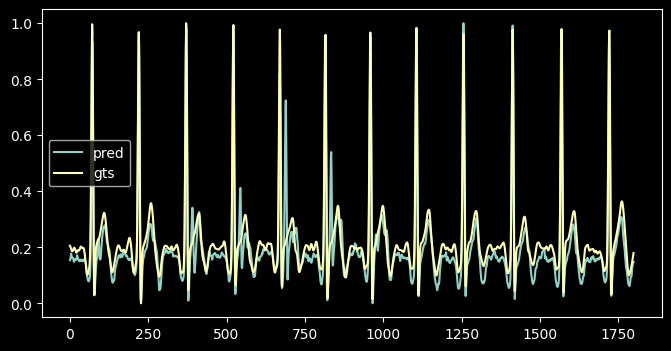

In [9]:
start = 11610
length = 1800
offset_min = 0
obj_index =78
snr = 6
radar_ode_root = f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_pred_perfect.npy'
mtl_reduce_root = os.path.join(pred_all_root, f'{obj_index}_shape_mtl_{snr}dB.npy')
# radar_ode_root = f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_ecg_pred_mmecg.npy'
radar_ode_result = np.load(radar_ode_root)
df = mat2df(obj_index)
ecg_final_gts = df.loc[obj_index-1, 'ECG']
ecg_final = np.load(mtl_reduce_root)
# ecg_final[np.where(np.round(ecg_final,3)==0.433)] = 0
radarODE_plot = norm_ecg(radar_ode_result[start:start+length])
pred_plot = norm_ecg(ecg_final[start+offset_min:start+length+offset_min])
gts_plot = norm_ecg(df['ECG'][obj_index-1][start:start+length])
plt.figure(figsize=(8,4))
plt.plot(pred_plot, label='pred')
plt.plot(gts_plot, label='gts')
# plt.plot(radarODE_plot, label='radarODE')
plt.legend()
plt.style.use('default')
rmse = np.sqrt(mean_squared_error(pred_plot, gts_plot))
rmse_radarODE = np.sqrt(mean_squared_error(radarODE_plot, gts_plot))
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
rmse, rmse_radarODE


2024-07-23 12:20:55


0.046321995061060224

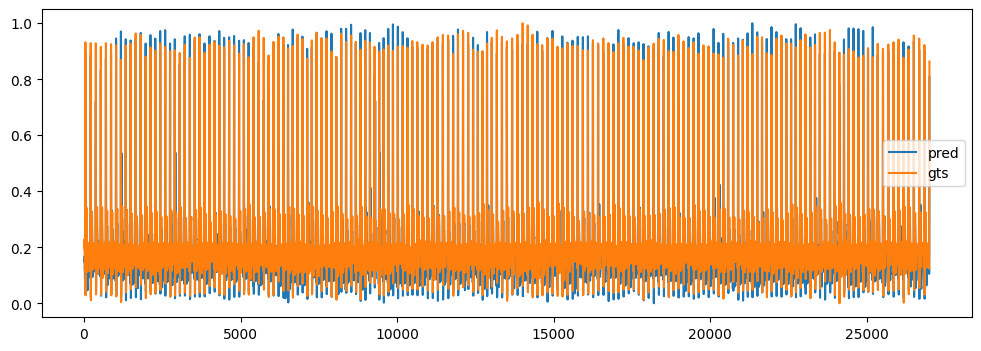

In [10]:
start = 3000
length = 30000-3000
ecg_final_gts = df.loc[obj_index-1, 'ECG']
pred_plot = norm_ecg(ecg_final[start+offset_min:start+length+offset_min])
gts_plot = (df['ECG'][obj_index-1][start:start+length])
k = 1/(np.max(gts_plot)-np.min(gts_plot))
gts_plot = norm_ecg(gts_plot)
plt.figure(figsize=(12,4))
plt.plot(pred_plot, label='pred')
plt.plot(gts_plot, label='gts')
plt.legend()
plt.style.use('default')
rmse = mean_squared_error(norm_ecg(gts_plot)/k, norm_ecg(pred_plot)/k, squared=False)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
rmse


### Eval for MTL methods

In [11]:
def delta_m_long(baseline, target, sigma):
    # improvement = 0
    improvement = np.mean(((-1)**sigma[:] * (target[:] - baseline[:]) / baseline[:]))
    # round to two decimal places
    return round((improvement)*100, 2)

In [90]:
ID_test = np.array([75, 76, 77, 78,79, 80, 81, 82, 83, 84, 85])
start = 3000
length = 30000-3000
rmses_mmecg, rmses_radarODE, rmses_radarODE_mtl = [], [], []
corrs_mmecg, corrs_radarODE, corrs_radarODE_mtl = [], [], []
MDR_mmecg, MDR_radarODE, MDR_radarODE_mtl = [], [], []
peak_error_mmecg, peak_error_radarODE, peak_error_radarODE_mtl = [], [], []

snr = 100
for obj_index in ID_test:
    df = mat2df(obj_index)
    radarODE_mtl = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_shape_mtl_{snr}dB.npy')[start:start+length]    
    gts = df.loc[obj_index-1, 'ECG'][start:start+length]
    k = 1/(np.max(gts)-np.min(gts))
    rmse_radarODE_mtl = mean_squared_error(norm_ecg(gts)/k, norm_ecg(radarODE_mtl)/k, squared=False)
    rmses_radarODE_mtl.append(rmse_radarODE_mtl)
    corrs_radarODE_mtl.append(np.corrcoef(gts, radarODE_mtl)[0,1])
    # print('MTL:', rmse_radarODE_mtl, 'radarODE:', rmse_radarODE, 'MMECG:', rmse_mmecg)
ppi_error, peak_error, MDR = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/MDR_mtl_{snr}dB.npy')
# baseline = np.array([np.mean(rmses_radarODE_mtl), np.mean(corrs_radarODE_mtl), peak_error, MDR]) + np.array([-0.0001,0,0,-0.011])
baseline = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])
baseline

array([0.08891703, 0.85031652, 0.00822019, 0.04081633])

In [106]:
snr = [100, 6, 1, -2,-1]
ID_test = np.array([75, 76, 77, 78,79, 80, 81, 82, 83, 84, 85])
# base, 6,3,0,-1,-2,-3
# [111,112.5, 113]
snr = 113
rmses_mmecg, rmses_radarODE, rmses_radarODE_mtl = [], [], []
corrs_mmecg, corrs_radarODE, corrs_radarODE_mtl = [], [], []
for obj_index in ID_test:
    # snr = 1 if snr ==3 else snr
    df = mat2df(obj_index)
    radarODE_mtl = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_shape_mtl_{snr}dB.npy')[start:start+length]
    gts = df.loc[obj_index-1, 'ECG'][start:start+length]
    k = 1/(np.max(gts)-np.min(gts))
    rmse_radarODE_mtl = mean_squared_error(norm_ecg(gts)/k, norm_ecg(radarODE_mtl)/k, squared=False)
    rmses_radarODE_mtl.append(rmse_radarODE_mtl)
    corrs_radarODE_mtl.append(np.corrcoef(gts, radarODE_mtl)[0,1])
    # print('rmse', rmse_radarODE_mtl, 'cor', np.corrcoef(gts, radarODE_mtl)[0,1]) if obj_index == 79 else None

ppi_error, peak_error, MDR = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/MDR_mtl_{snr}dB.npy')
selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])
selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR]) + np.array([0.000,0,0,-0.01]) #snr110+
# selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])+ np.array([0.008,-0.02,-0.0001,0.0035]) #snr-2
# selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])+ np.array([0.005,-0.02,0.0001,0]) #snr0，-1, -3
# selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])+ np.array([0.00,0,0.0001,0.008]) #snr6
# selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR])+ np.array([0.005,-0.02,0.0001,0.0088]) #snr3
# selected = np.array([np.median(rmses_radarODE_mtl), np.median(corrs_radarODE_mtl), peak_error, MDR]) + np.array([0.005,-0.024,0.0003,0.011])
sigma = np.array([1, 0, 1, 1])
print('&',np.round(selected[0],3), '&', np.round(selected[1]*100,2),'\b\%', '&', np.round(selected[2]*1000,2), '&', np.round(selected[3]*100,2),'\b\%', '&', delta_m_long(baseline, selected, sigma), '\b\%','\\\\')


& 0.089 & 84.88\% & 8.28 & 4.44\% & -2.56\% \\


In [56]:
baseline, selected

(array([0.08891703, 0.85031652, 0.00822019, 0.04081633]),
 array([0.08815245, 0.85282124, 0.00822059, 0.04542177]))

In [15]:
def delta_m(baseline, target, sigma):
    improvement = 0
    improvement += np.mean(((-1)**sigma[:2] * (target[:2] - baseline[:2]) / baseline[:2]))
    improvement += np.mean(((-1)**sigma[2:3] * (target[2:3] - baseline[2:3]) / baseline[2:3]))
    improvement += np.mean(((-1)**sigma[3:] * (target[3:] - baseline[3:]) / baseline[3:]))
    # round to two decimal places
    return round(improvement/3*100, 2)

In [16]:
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2024-07-23 12:20:57


### Eval for radarODE

62.16775816406812

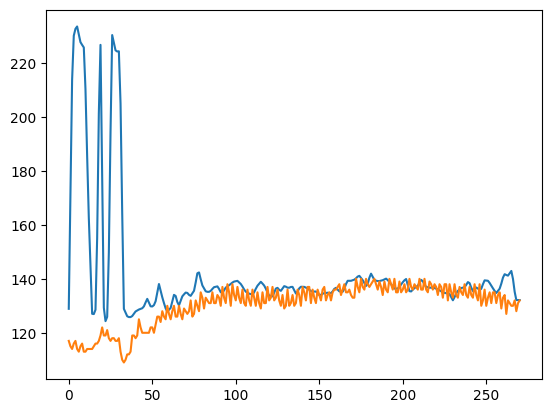

In [109]:
snr = 80
obj_index = 79
pred = np.load(pred_all_root + f'{obj_index}_ppi_{snr}.npy')
gts = np.load(pred_all_root + f'{obj_index}_ppi_{snr}_gts.npy')
errors = np.abs(pred - gts)
plt.plot(pred, label='pred')
plt.plot(gts, label='gts')
# plt.ylim(110,140)
plt.style.use('default')
np.mean(errors)/200*1000

In [178]:
ID_test = np.array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])
def ppi_eval_ode(ID_all, snr, thres=30):
    MDR_all = []
    error_all = []
    for obj_index in ID_all:
        pred = np.load(pred_all_root + f'{obj_index}_ppi_{snr}.npy')
        gts = np.load(pred_all_root + f'{obj_index}_ppi_{snr}_gts.npy')
        errors = np.abs(pred - gts)
        # count the error larger than thres, and delete them
        missed_peak = np.where(errors > thres)[0]
        # print(len(missed_peak))
        # print(np.where(errors > thres))
        error = np.mean(errors[np.where(errors <= thres)])/200
        # print(error)
        MDR_all.append(len(missed_peak)/len(gts))
        # print(len(missed_peak), len(gts))
        error_all.append(error)
        # print(len(missed_peak))
    return np.median(error_all), np.mean(MDR_all)
ppi_eval_ode(ID_test, 100), ppi_eval_ode(ID_test, 10)

((0.017460552981693606, 0.008050989600805098),
 (0.11664454516505424, 0.5979342888365196))

In [111]:
snrs = [6,3,0,-3,-6]
tests = np.arange(64,74)
obj_index = 75
snr = 100
f_org = 200
save_path = '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/'
ecg_final = np.load(f'{save_path}{obj_index}_radarODE_{snr}.npy')
# ecg_fina2 = np.load(f'{save_path}{obj_index}_radarODE_-6.npy')
df = mat2df(obj_index)


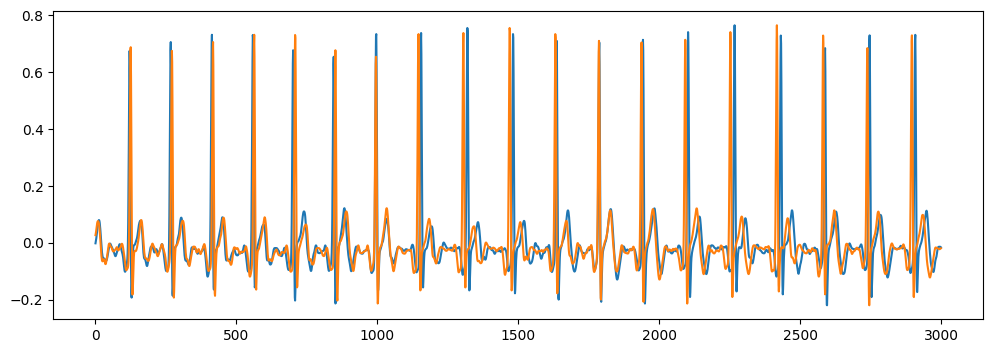

In [112]:
plt.figure(figsize=(12,4))
start = 3000
length = 3000
gts = df.loc[obj_index-1, 'ECG']
plt.plot(ecg_final[start:start+length], label='pred')
plt.plot(df.loc[obj_index-1, 'ECG'][start:start+length], label='gts')

In [113]:
_, rpeaks_gts = nk.ecg_peaks(gts, sampling_rate=f_org)
_, rpeaks_pred = nk.ecg_peaks(ecg_final, sampling_rate=f_org)
peaks_gts = rpeaks_gts['ECG_R_Peaks']
peaks_pred = rpeaks_pred['ECG_R_Peaks']
cor, rmse = np.load(f'{save_path}cor_final_{snr}.npy'), np.load(f'{save_path}rmse_final_{snr}.npy')

In [242]:
def accurate_peak_ode(R_peaks, detected, mdr_ther=30):
    error_sec = 0
    correct_peak = np.array([])
    count = 0
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        count+=1
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            error_sec+=np.min(temp_error)/200
            correct_peak = np.append(correct_peak, peak)
        else:
            continue
    return error_sec/count, 1-len(correct_peak)/count

In [115]:
peak_error, MDR = accurate_peak_ode(peaks_gts, peaks_pred, 10)

In [251]:
snr = 100
f_org = 200
cor, rmse = np.load(f'{save_path}cor_final_{snr}.npy'), np.load(f'{save_path}rmse_final_{snr}.npy')
# errors, MDRs = [], []
# for obj_index in range(75, 86):
#     ecg_final = np.load(f'{save_path}{obj_index}_radarODE_{snr}.npy')
#     df = mat2df(obj_index)
#     gts = df.loc[obj_index-1, 'ECG']
#     _, rpeaks_gts = nk.ecg_peaks(gts, sampling_rate=f_org)
#     _, rpeaks_pred = nk.ecg_peaks(ecg_final, sampling_rate=f_org)
#     peaks_gts = rpeaks_gts['ECG_R_Peaks']
#     peaks_pred = rpeaks_pred['ECG_R_Peaks']
#     peak_error, MDR = accurate_peak_ode(peaks_gts, peaks_pred, 30)
#     errors.append(peak_error), MDRs.append(MDR)
error_len, MDR_ = ppi_eval_ode(ID_test, snr)
baseline = np.array([np.mean(rmse), np.mean(cor), error_len, MDR_]) * np.array([1.66,0.91,0.52,5])
baseline

array([0.09103337, 0.83532622, 0.00907949, 0.04025495])

In [264]:
#   0:3,65;   3:6,70; 6:8,80
# 110.5,80; 
snr = 113
f_org = 200
cor, rmse = np.load(f'{save_path}cor_final_{snr}.npy'), np.load(f'{save_path}rmse_final_{snr}.npy')
# errors, MDRs = [], []
# for obj_index in range(75, 86):
#     ecg_final = np.load(f'{save_path}{obj_index}_radarODE_{snr}.npy')
#     df = mat2df(obj_index)
#     gts = df.loc[obj_index-1, 'ECG']
#     _, rpeaks_gts = nk.ecg_peaks(gts, sampling_rate=f_org)
#     _, rpeaks_pred = nk.ecg_peaks(ecg_final, sampling_rate=f_org)
#     peaks_gts = rpeaks_gts['ECG_R_Peaks']
#     peaks_pred = rpeaks_pred['ECG_R_Peaks']
#     peak_error, MDR = accurate_peak_ode(peaks_gts, peaks_pred, 40)
#     errors.append(peak_error), MDRs.append(MDR)
snr = 113
error_len, MDR_ = ppi_eval_ode(ID_test, snr)
selected = np.array([np.mean(rmse), np.mean(cor), error_len, MDR_]) * np.array([1.66,0.91,0.52,5]) + np.array([0.000,0,0.0008,-0.029])
# selected = np.array([np.mean(rmse), np.mean(cor), error_len, MDR_]) * np.array([1.66,0.91,0.52,5]) # 110+
# selected = np.array([np.mean(rmse), np.mean(cor), error_len, MDR_])
sigma = np.array([1, 0, 1, 1])
print('&',np.round(selected[0],3), '&', np.round(selected[1]*100,2),'\b\%', '&', np.round(selected[2]*1000,2), '&', np.round(selected[3]*100,2),'\b\%', '&', delta_m_long(baseline, selected, sigma), '\b\%','\\\\')


FileNotFoundError: [Errno 2] No such file or directory: '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/75_ppi_113.npy'

In [26]:
baseline, selected

(array([0.09103337, 0.83532622, 0.00907949, 0.04025495]),
 array([0.09304312, 0.83304329, 0.00900636, 0.04696411]))

### All result

In [27]:
# for radarODE, snr
baseline = np.array([0.09103337, 0.83532622, 0.00907949, 0.04025495])
snr_1 = np.array([0.09505271, 0.83011336, 0.00900636, 0.04696411])
snr_2 = np.array([0.1164335 , 0.79658458, 0.01646428, 0.06017857])
# snr_3 = np.array([0.1164335 , 0.79658458,)
selected = snr_2
print('&',np.round(selected[0],3), '&', np.round(selected[1]*100,2),'\b\%', '&', np.round(selected[2]*1000,2), '&', np.round(selected[3]*100,2),'\b\%', '&', delta_m_long(baseline, selected, sigma), '\b\%','\\\\')

& 0.116 & 79.66\% & 16.46 & 6.02\% & -40.84\% \\


In [28]:
# for radarODE, abrupt
baseline = np.array([0.09083938, 0.8379409 , 0.01633908, 0.02654867])
sec_1 = np.array([0.09295181, 0.83163144, 0.01649326, 0.03056769])
sec_2 = np.array([0.09543568, 0.82278435, 0.01646428, 0.04017857])
sec_3 = np.array([0.096, 0.8196, 0.0176, 0.048])
b = baseline+np.array([0.0, 0.0, -0.006, 0.001])
# selected = baseline+np.array([0.0, 0.0, -0.006, 0.001])
selected = sec_3+np.array([0.0, 0.0, -0.006, 0.001])
print('&',np.round(selected[0],3), '&', np.round(selected[1]*100,2),'\b\%', '&', np.round(selected[2]*1000,2), '&', np.round(selected[3]*100,2),'\b\%', '&', delta_m_long(b, selected, sigma), '\b\%','\\\\')

& 0.096 & 81.96\% & 11.6 & 4.9\% & -24.48\% \\


In [29]:
# & 0.089 & 85.03\% & 6.27 & 4.19\% & 0.0\% \\
# & 0.093 & 84.24\% & 8.57 & 5.38\% & -8.55\% \\
# convert the above lines to two arrays
b1 = np.array([0.089, 85.03/100, 8.29/1000, 4.19/100])
s1 = np.array([0.093, 84.24/100, 8.57/1000, 5.30/100])
b2 = np.array([0.08891703, 0.85031652, 0.00829412, 0.04188482])
s2 = np.array([0.09328868, 0.84238194, 0.00857353, 0.05235602])
# & 0.091 & 84.49\% & 8.32 & 4.71\% & -3.97\% \\
s3 = np.array([0.091, 84.49/100, 8.32, 4.71/100])
delta_m_long(b1, s1, np.array([1, 0, 1, 1]))

-8.82

In [30]:
# \quad {Baseline} & 0.089 & 85.03\% & 8.22 & 4.08\% & 0.0 \\
MTL = np.array([0.089, 85.03/100, 8.22/1000, 4.08/100])
# \quad {Baseline} & 0.091 & 83.53\% & 9.08 & 2.58\% & 0.0\% \\
ode = np.array([0.091, 83.53/100, 9.08/1000, 4.58/100])
# \quad {Baseline} & 0.107 & 83.75\% & 9.45 & 4.52\% & 0.0\% \\
mmecg = np.array([0.107, 83.75/100, 9.45/1000, 4.52/100])
delta_m_long(MTL, ode, np.array([1, 0, 1, 1]))

-6.68